# 프로젝트: 한영 번역기 만들기

## 라이브러리 버전을 확인해 봅니다

In [1]:
import pandas
import tensorflow
import matplotlib

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.3
2.6.0
3.4.3


# Load Libraries

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
# 데이터 준비하기
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.6.0


In [4]:
from tqdm import tqdm, trange

tqdm.pandas()

# Step 1. 데이터 다운로드
아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

- jungyeul/korean-parallel-corpora

In [5]:
# !pip install Korpora

In [6]:
from Korpora import Korpora
# Korpora.fetch("korean_parallel_koen_news")

In [7]:
corpus = Korpora.load("korean_parallel_koen_news")


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : KakaoBrain
    Repository : https://github.com/jungyeul/korean-parallel-corpora
    References :
        - Jungyeul Park, Jeen-Pyo Hong and Jeong-Won Cha (2016) Korean Language Resources for Everyone.
          In Proceedings of the 30th Pacific Asia Conference on Language, Information and Computation
          (PACLIC 30). October 28 - 30, 2016. Seoul, Korea. 
          (https://www.aclweb.org/anthology/Y16-2002/)

    # License
    Creative Commons Attribution Noncommercial No-Derivative-Works 3.0
    Details in https://creativecommons.org/licenses/by-nc-nd/3.0/



In [8]:
corpus.train[0].text

'개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"'

In [9]:
corpus.train[0].pair

'Much of personal computing is about "can you top this?"'

In [96]:
corpus.train.get_all_texts()[:5]

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"',
 '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.',
 '그러나 이것은 또한 책상도 필요로 하지 않는다.',
 '79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.',
 '정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.']

In [97]:
corpus.train.get_all_pairs()[:5]

['Much of personal computing is about "can you top this?"',
 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.',
 "Like all optical mice, But it also doesn't need a desk.",
 'uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.',
 "Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack."]

# Step 2. 데이터 정제
1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [12]:
ko = corpus.train.get_all_texts()
en = corpus.train.get_all_pairs()

In [13]:
df = pd.DataFrame({'ko':ko,'en':en})
df.head()

,ko,en
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


In [14]:
df.iloc[3].en

'uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.'

In [15]:
df = df.drop_duplicates()

In [16]:
cleaned_corpus = [df.ko.tolist(), df.en.tolist()]

## 전처리

- 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!
> - 문장부호 앞 뒤로 공백 추가
> - 큰 따옴표 제거
> - 영어, 한글, ?,.! 제외한 문자 삭제

- 성능이 너무 안나오기 때문에 (THE의 빈도가 너무 높아서 the의 확률이 너무 높게 나와서 the만 decode하는 결과가 계속 나왔기 때문에 the를 stopwords 추가하는 실험을 진행
- 결과적으로 the를 빼면 그나마 잘 나왔지만 그렇게 되면 .만 나오게 되는 경우도 발생하였음
- 이는 underfitting 문제임을 파악하였고, dropout layer와 epoch를 늘려주어서 해결하였다
- 이에 따라 아래 학습은 stopwords는 넣지 않고 진행할 것이며 ,도 학습에 방해가 되는 것으로 보였기에 ,는 제거하였다

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 문장부호 앞 뒤로 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 큰 따옴표 제거
    sentence = re.sub(r"[^a-zA-Z가-힣?.!]+", " ", sentence)
    sentence = sentence.lstrip('.?! ')
    sentence = sentence.strip()
    sentence = ' '.join(sentence.split())
    
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence


In [19]:
# 인코더의 입력이 될 한글 문장
cleaned_ko = [preprocess_sentence(x) for x in cleaned_corpus[0]] 

# target 문장
cleaned_en = [preprocess_sentence(x, s_token=True, e_token=True) for x in cleaned_corpus[1]]

In [20]:
cleaned_ko[:5]

['개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?',
 '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다 .',
 '그러나 이것은 또한 책상도 필요로 하지 않는다 .',
 '달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 팔 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다 .',
 '정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을 밝혔으며 세계 해상 교역량의 거의 분의 을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다 .']

In [21]:
cleaned_en[:5]

['<start> much of personal computing is about can you top this ? <end>',
 '<start> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable wireless mouse . <end>',
 '<start> like all optical mice but it also doesn t need a desk . <end>',
 '<start> uses gyroscopic sensors to control the cursor movement as you move your wrist arm whatever through the air . <end>',
 '<start> intelligence officials have revealed a spate of foiled plots on ships in southeast asia and are warning that a narrow stretch of water carrying almost one third of the world s maritime trade is vulnerable to a terror attack . <end>']

## 토큰화

- 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 
- 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

In [22]:
from konlpy.tag import Mecab

In [23]:
mecab = Mecab()

In [24]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

In [25]:
# nltk.download('punkt')

In [26]:
kor_corpus = [mecab.morphs(sentence) for sentence in tqdm(cleaned_ko)]

100%|██████████| 78968/78968 [00:11<00:00, 6791.24it/s]


In [27]:
eng_corpus = [sentence.split() for sentence in tqdm(cleaned_en)]

100%|██████████| 78968/78968 [00:00<00:00, 146351.61it/s]


In [28]:
# stop_words = set(stopwords.words('english'))

In [98]:
' / '.join(eng_corpus[5])

'<start> / the / institute / of / medicine / is / part / of / the / national / academy / of / sciences / a / private / organization / chartered / by / congress / to / advise / the / government / on / scientific / matters / . / <end>'

In [30]:
# eng_corpus = [[words for words in sents if words != 'the'] for sents in eng_corpus]

## 토큰의 길이 확인

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.



> 추가적으로 각 샘플들의 길이를 확인해서 길이 7이하, 4이하는 데이터를 확인하여 이상한 데이터였기에 제거하고자 함
> - kor_corpus에서 길이가 7미만, 40초과 제거
> - eng_corpus에서 길이가 4미만, 40초과 제거

In [31]:
def check_token_len(corpus):
    print('토큰의 최소 길이 :',min(len(l) for l in corpus))
    print('토큰의 최대 길이 :',max(len(l) for l in corpus))
    print('토큰의 평균 길이 :',sum(map(len, corpus))/len(corpus))
    plt.hist([len(s) for s in corpus], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show();

토큰의 최소 길이 : 0
토큰의 최대 길이 : 121
토큰의 평균 길이 : 28.403999088238272


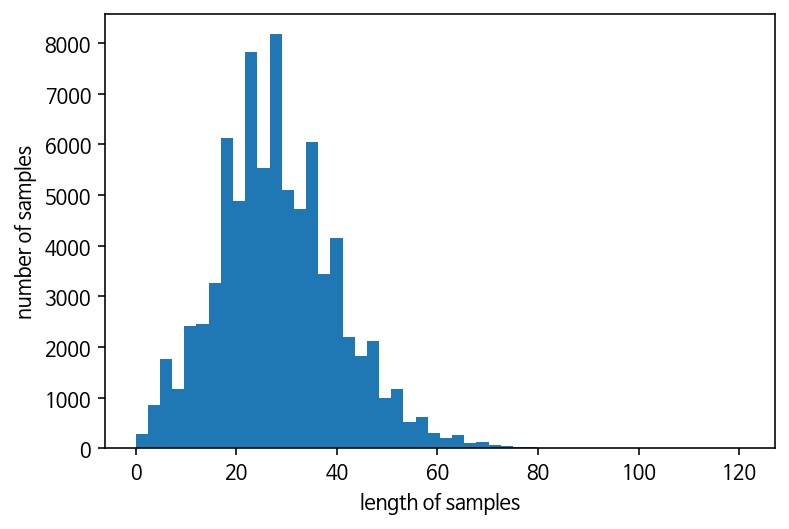

In [32]:
check_token_len(kor_corpus)

토큰의 최소 길이 : 2
토큰의 최대 길이 : 98
토큰의 평균 길이 : 25.61612298652619


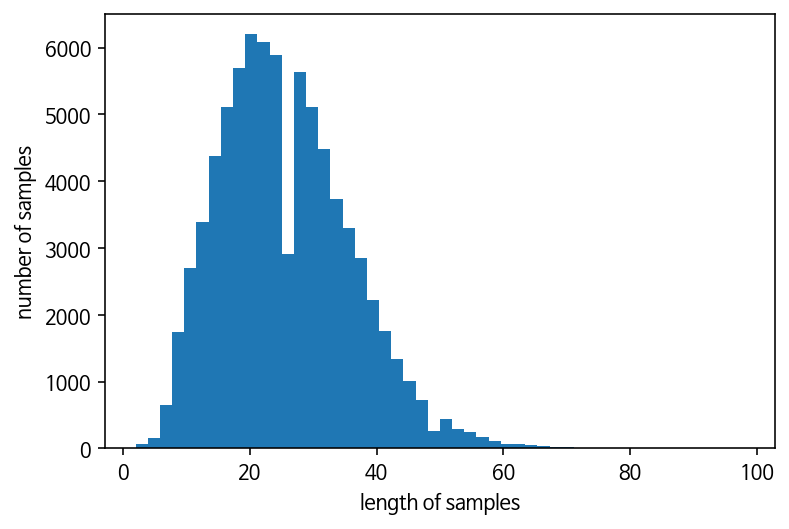

In [33]:
check_token_len(eng_corpus)

In [34]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [35]:
max_len = 40
below_threshold_len(max_len, kor_corpus)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 84.88881572282445


In [36]:
below_threshold_len(max_len, eng_corpus)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 91.58266639651504


In [37]:
[l for l in kor_corpus if len(l) < 7][:10]

[['어휘'],
 ['어휘'],
 ['선례', '가', '하나', '있', '다', '.'],
 ['그것', '은', '큰', '문제', '입니다', '.'],
 ['어휘'],
 ['난', '롱', '죤', '액티브', '라구', '.'],
 ['낙태', '는', '불법', '이', '다', '.'],
 ['하', '는', '질문', '이', '아닙니다', '.'],
 ['모르', '고', '있', '습니다', '.'],
 ['네', '보이', '는군요', '.']]

In [38]:
[l for l in eng_corpus if len(l) < 4][:10]

[['<start>', 'sommelier', '<end>'],
 ['<start>', 'typos', '<end>'],
 ['<start>', 'men', '<end>'],
 ['<start>', 'family', '<end>'],
 ['<start>', 'lifeguards', '<end>'],
 ['<start>', 'food', '<end>'],
 ['<start>', 'sunlight', '<end>'],
 ['<start>', '<end>'],
 ['<start>', 'fruits', '<end>'],
 ['<start>', 'onions', '<end>']]

In [39]:
def drop_empty_list(kor_corpus, eng_corpus):    
    drop_kor = [index for index, sentence in enumerate(kor_corpus) 
                if (len(sentence) < 7) or (len(sentence) > 40)]
    print(f'제거하고자 하는 한글 샘플 수 : {len(drop_kor)}')
    
    drop_eng = [index for index, sentence in enumerate(eng_corpus)
                if (len(sentence) < 4) or (len(sentence) > 40)]
    print(f'제거하고자 하는 영어 샘플 수 : {len(drop_eng)}')
    
    drop_data = set(drop_kor) | set(drop_eng)
    drop_data = list(drop_data)
    print(f'제거하고자 하는 총 샘플 수 : {len(drop_data)}')

    # 빈 샘플 제거
    kor_corpus = np.delete(kor_corpus, drop_data, axis=0)
    eng_corpus = np.delete(eng_corpus, drop_data, axis=0)
    print(f'빈 샘플 제거 후 남은 kor_corpus data : {len(kor_corpus)}')
    print(f'빈 샘플 제거 후 남은 eng_corpus data : {len(eng_corpus)}')
    return kor_corpus, eng_corpus

In [40]:
kor_corpus, eng_corpus = drop_empty_list(kor_corpus, eng_corpus)

제거하고자 하는 한글 샘플 수 : 14181
제거하고자 하는 영어 샘플 수 : 6713
제거하고자 하는 총 샘플 수 : 16900
빈 샘플 제거 후 남은 kor_corpus data : 62068
빈 샘플 제거 후 남은 eng_corpus data : 62068


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


토큰의 최소 길이 : 4
토큰의 최대 길이 : 40
토큰의 평균 길이 : 22.95701488689824


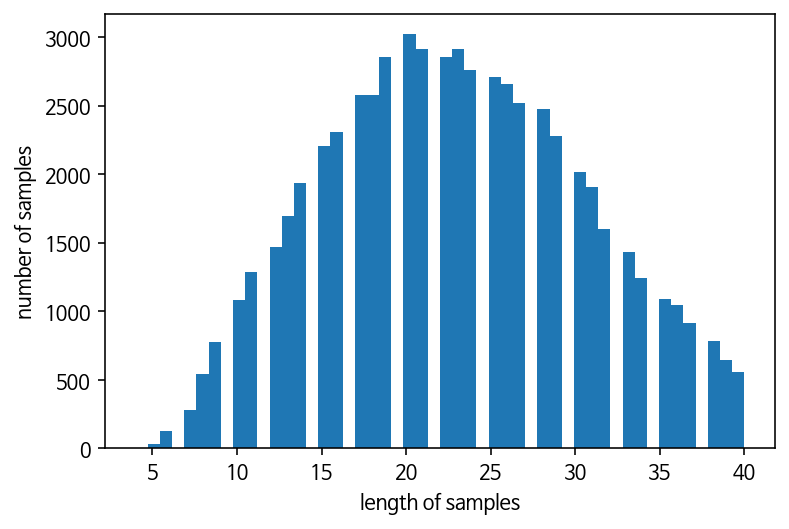

토큰의 최소 길이 : 7
토큰의 최대 길이 : 40
토큰의 평균 길이 : 25.23868982406393


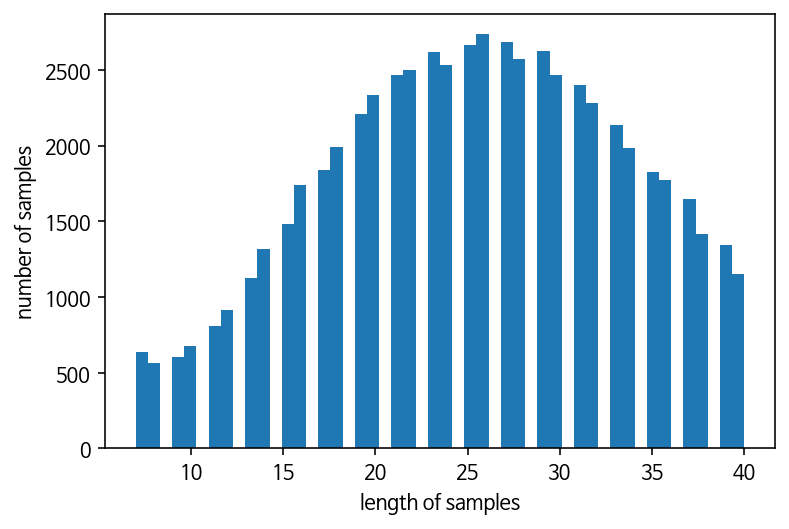

In [41]:
check_token_len(eng_corpus)
check_token_len(kor_corpus)

# Step 3. 데이터 토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

In [42]:
def tokenize(corpus, num_words, reverse=False):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    if reverse:
        tensor = np.flip(tensor, axis=1)
    
    return tensor, tokenizer

In [43]:
num_words = None

In [44]:
enc, enc_tokenizer = tokenize(kor_corpus, num_words, reverse=True)
dec, dec_tokenizer = tokenize(eng_corpus, num_words)

In [45]:
len(enc_tokenizer.word_index)

44091

In [46]:
len(dec_tokenizer.word_index)

38953

In [47]:
enc.shape, dec.shape

((62068, 40), (62068, 40))

In [48]:
enc

array([[   0,    0,    0, ...,  536,  597,  691],
       [   0,    0,    0, ..., 5803, 5428,  212],
       [   0,    0,    0, ...,    7,  703,   78],
       ...,
       [   0,    0,    0, ..., 1683,  354,   78],
       [   0,    0,    0, ...,   23,  666,  905],
       [   0,    0,    0, ...,  905,    7,   69]], dtype=int32)

In [49]:
dec

array([[  3, 273,   6, ...,   0,   0,   0],
       [  3, 142,   7, ...,   0,   0,   0],
       [  3, 161,  76, ...,   0,   0,   0],
       ...,
       [  3,  31,   1, ...,   0,   0,   0],
       [  3, 286,   9, ...,   0,   0,   0],
       [  3,  61,  30, ...,   0,   0,   0]], dtype=int32)

# Step 4. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

> dropout은 Gru내부와 embedding layer 다음에 넣어주었다

In [50]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, 
                 dropout=0.0, recurrent_dropout=0.0):
        
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, 
                                       dropout=dropout,
                                       recurrent_dropout=recurrent_dropout,
                                       return_sequences=True,
                                       return_state=True,
                                      recurrent_initializer='glorot_uniform')
        
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x):

        x = self.embedding(x)
        # embedding layer 통과한 후에 dropout 추가
        x = self.dropout(x)

        output, state = self.gru(x)

        return output, state
    
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, 
                 dropout=0.0, recurrent_dropout=0.0):
        
        super(Decoder, self).__init__()
        
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       dropout=dropout,
                                       recurrent_dropout=recurrent_dropout,
                                       return_sequences=True, 
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        
        x = self.embedding(x)
        # embedding layer 통과한 후에 dropout 추가
        x = self.dropout(x)
        
        x = tf.concat([tf.expand_dims(context_vec, 1), x], axis=-1)
        
        x, h_dec = self.gru(x)
        x = tf.reshape(x, (-1, x.shape[2]))
        output = self.fc(x)
        
        return output, h_dec, attn

In [51]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
ENC_RECURRENT_DROPOUT = 0.0
DEC_RECURRENT_DROPOUT = 0.0

units         = 600
embedding_dim = 1000

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units, ENC_DROPOUT, ENC_RECURRENT_DROPOUT)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units, DEC_DROPOUT, DEC_RECURRENT_DROPOUT)

# Step 5. 훈련하기
훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

    ## 예문 ##
    K1) 오바마는 대통령이다.
    K2) 시민들은 도시 속에 산다.
    K3) 커피는 필요 없다.
    K4) 일곱 명의 사망자가 발생했다.

    ## 제출 ##
    E1) obama is the president . <end>
    E2) people are victims of the city . <end>
    E2) the price is not enough . <end>
    E2) seven people have died . <end>

> 결과 비교를 위해 10에폭 마다 시각화를 진행해봤다

### Optimizer & Loss

In [52]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

### train_step

In [53]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        
        # 1) Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
        enc_out, state = encoder(src)
        
        # 2) t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의
        h_dec = state
        
        # 3) Decoder에 입력으로 전달할 <start> 토큰 문장 생성
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            # 4) <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. 
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            
            # 5) 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용
            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [54]:
# !nvidia-smi

In [55]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

batch_losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    #tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc[idx:idx+BATCH_SIZE],
                                dec[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        
        batch_losses.append(batch_loss)
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 970/970 [06:16<00:00,  2.57it/s, Loss 2.7191]


In [56]:
dec_tokenizer.index_word[3]

'<start>'

## 10 epoch 결과

/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the attack was killed in the capital . <end> 


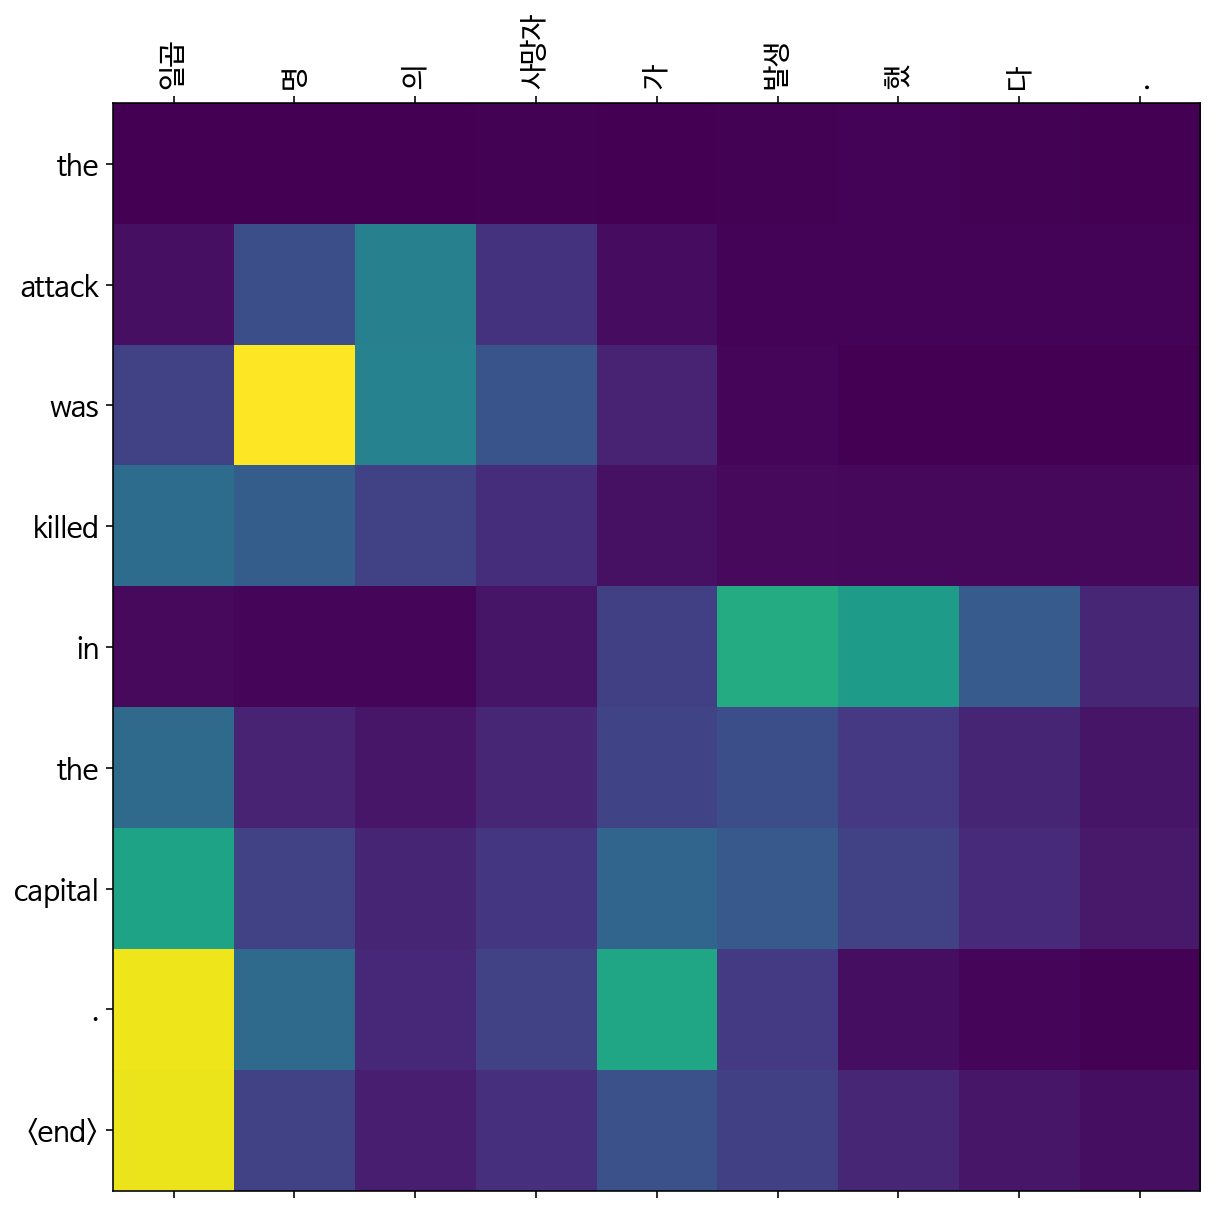

In [57]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec.shape[-1], enc.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([mecab.morphs(sentence)])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc.shape[-1],
                                                           padding='post')
    inputs = np.flip(inputs, axis=1)

    result = ''

    enc_out, state = encoder(inputs)

    dec_hidden = state
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        #predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(mecab.morphs(sentence))]
    plot_attention(attention, mecab.morphs(sentence), result.split(' '))
    
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

In [59]:
cases = ['오바마는 대통령이다.','시민들은 도시 속에 산다.','커피는 필요 없다.','일곱 명의 사망자가 발생했다.']

Input: 오바마는 대통령이다 .
Predicted translation: obama is the first time . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


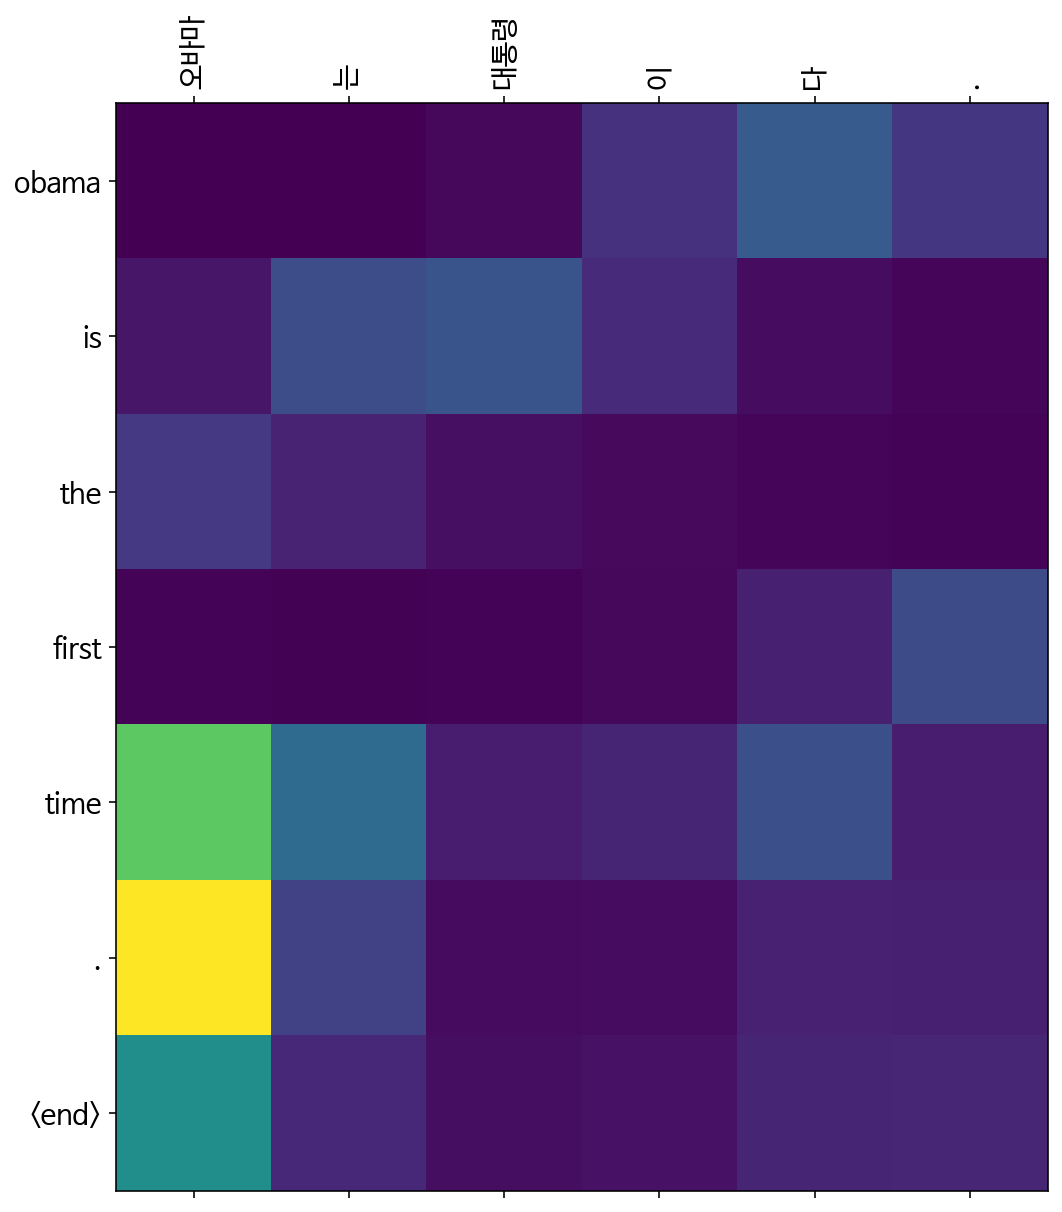

In [61]:
translate(cases[0], encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: the year old girl is the first time . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


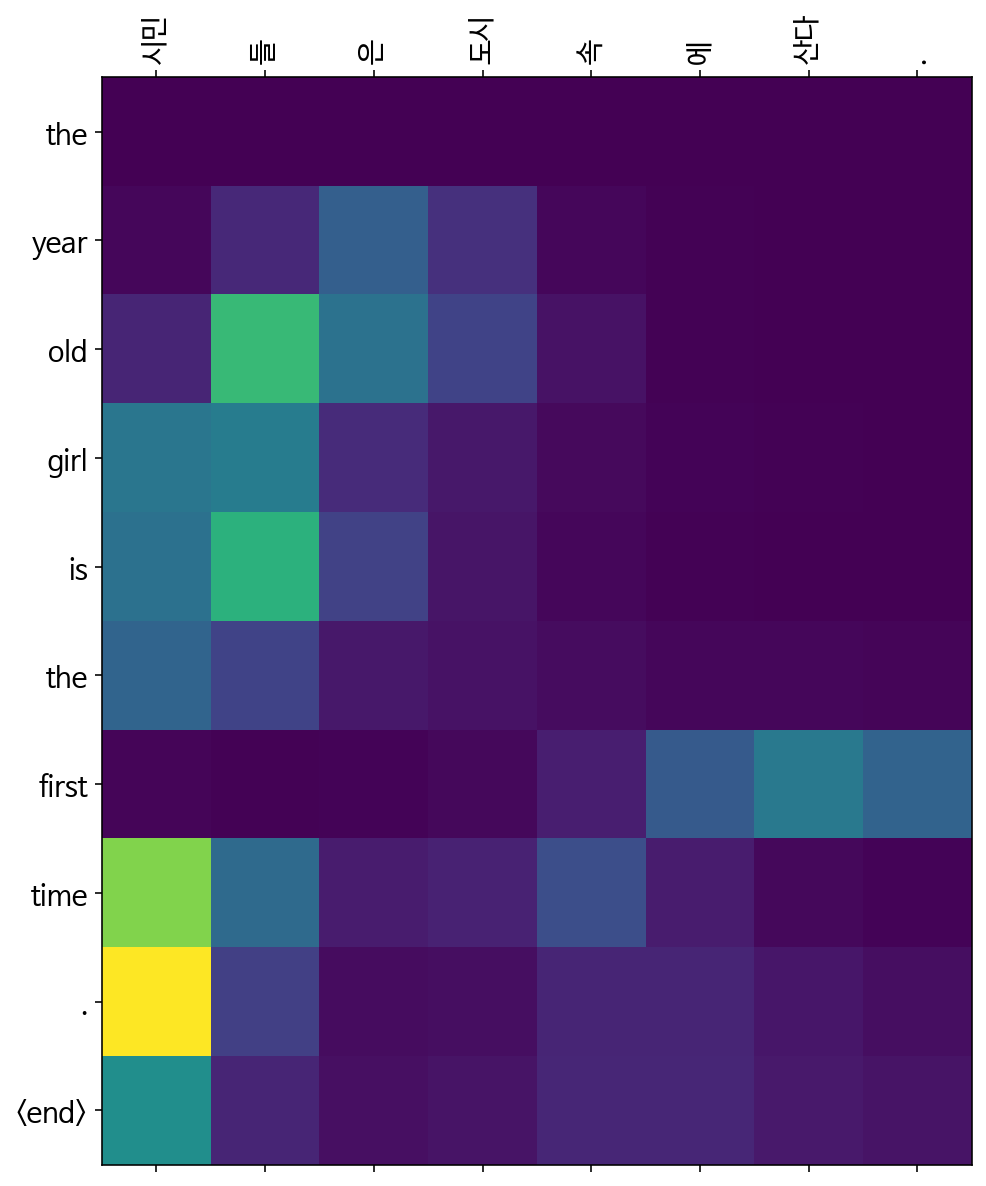

In [62]:
translate(cases[1], encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: i m a lot of the world s . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


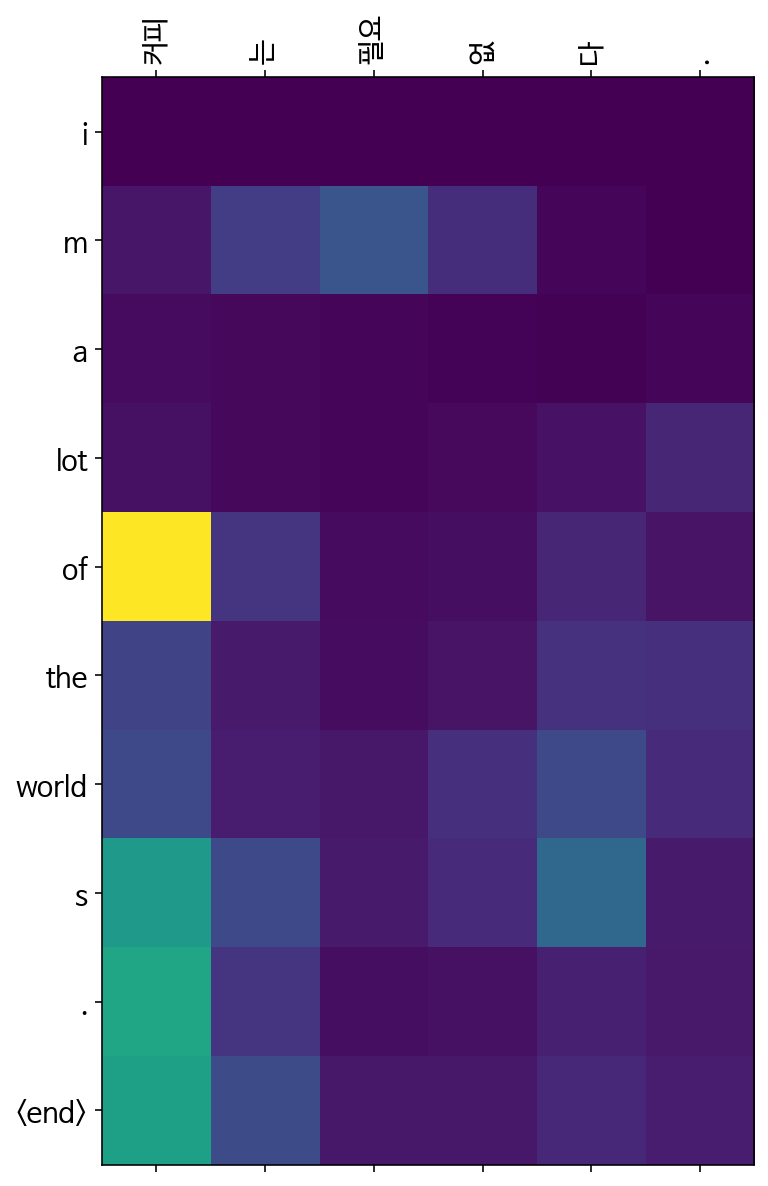

In [63]:
translate(cases[2], encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the attack was killed in the capital . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


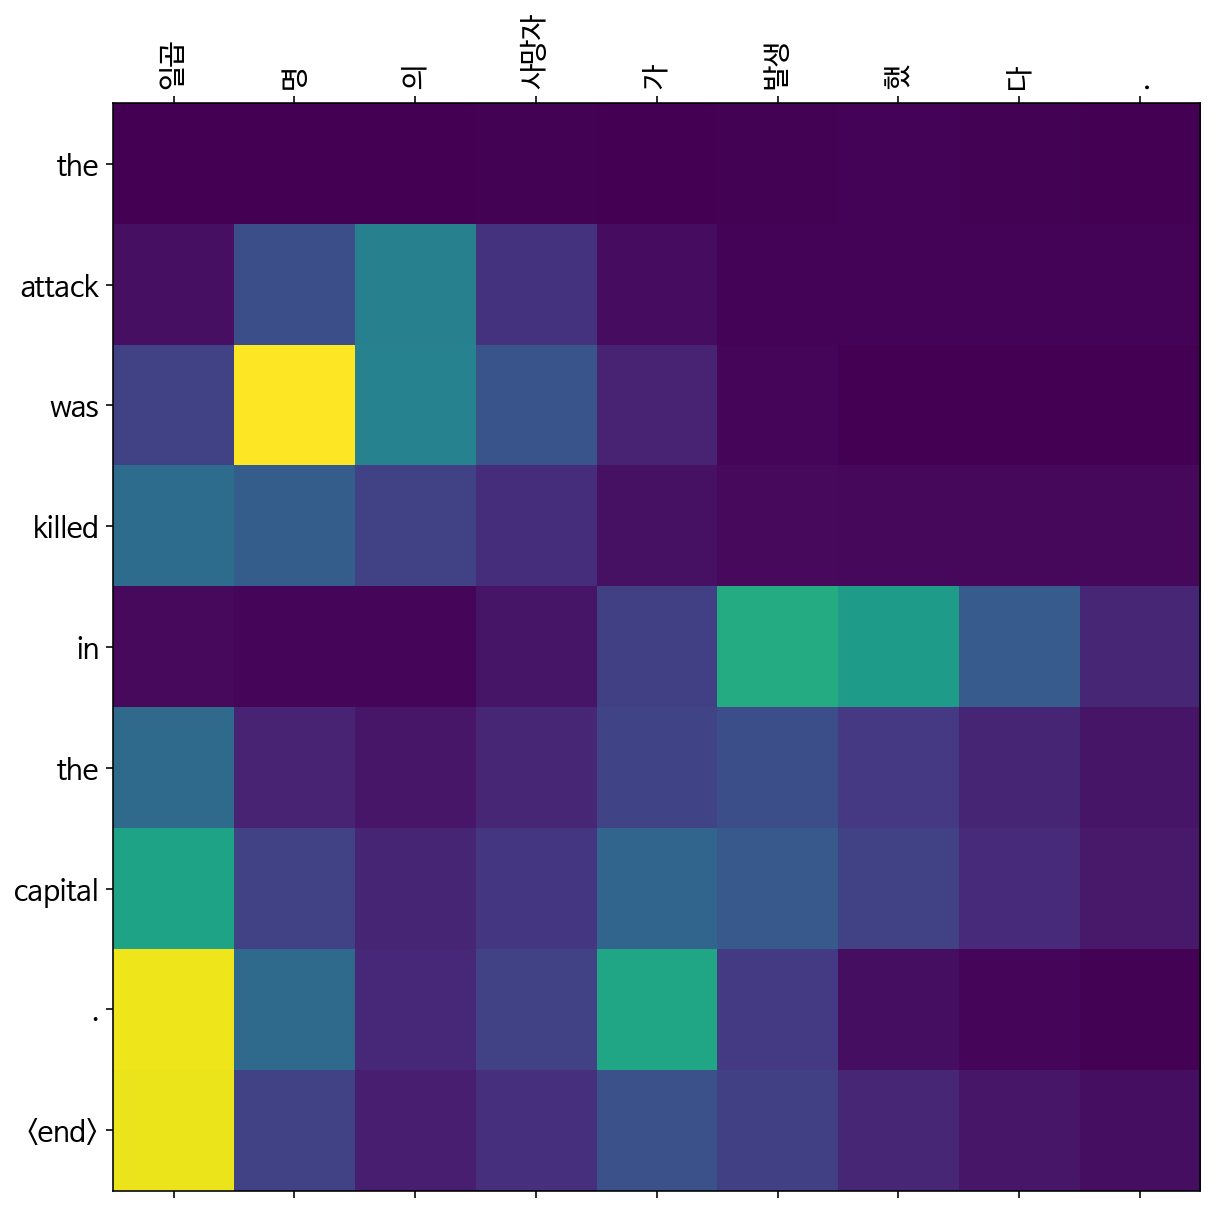

In [64]:
translate(cases[3], encoder, decoder)

## 20 epoch 결과

In [65]:
EPOCHS = 10
TRIALS = 1

# def more_train(EPOCHS, TRIALS, batch_losses):
# batch_losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    #tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc[idx:idx+BATCH_SIZE],
                                dec[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        
        batch_losses.append(batch_loss)
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + TRIALS*10 + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 20: 100%|██████████| 970/970 [06:17<00:00,  2.57it/s, Loss 2.1925]


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: 오바마는 대통령이다 .
Predicted translation: obama is the first time . <end> 


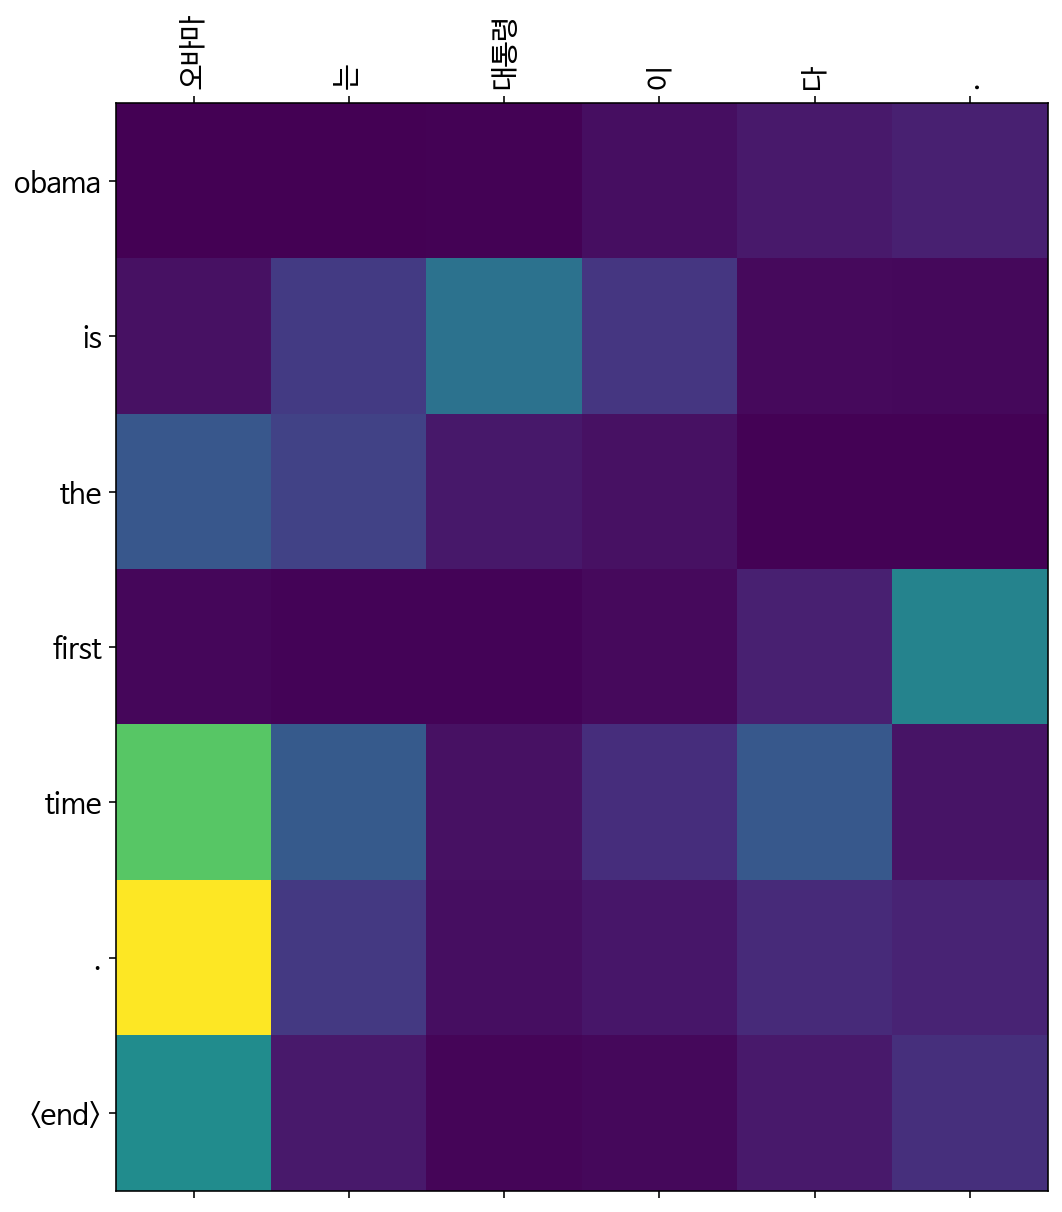

In [66]:
translate(cases[0], encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: they are also expected to be a major scale of the world . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


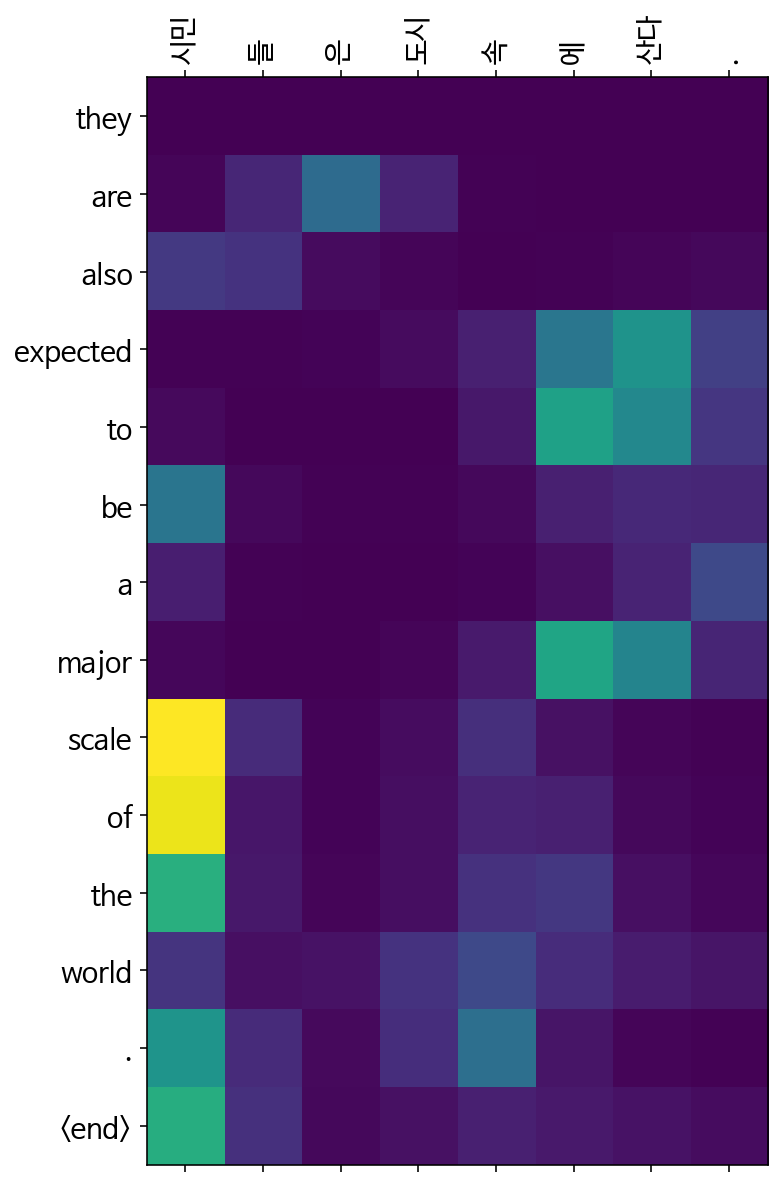

In [67]:
translate(cases[1], encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: it s not going to be a very good thing . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


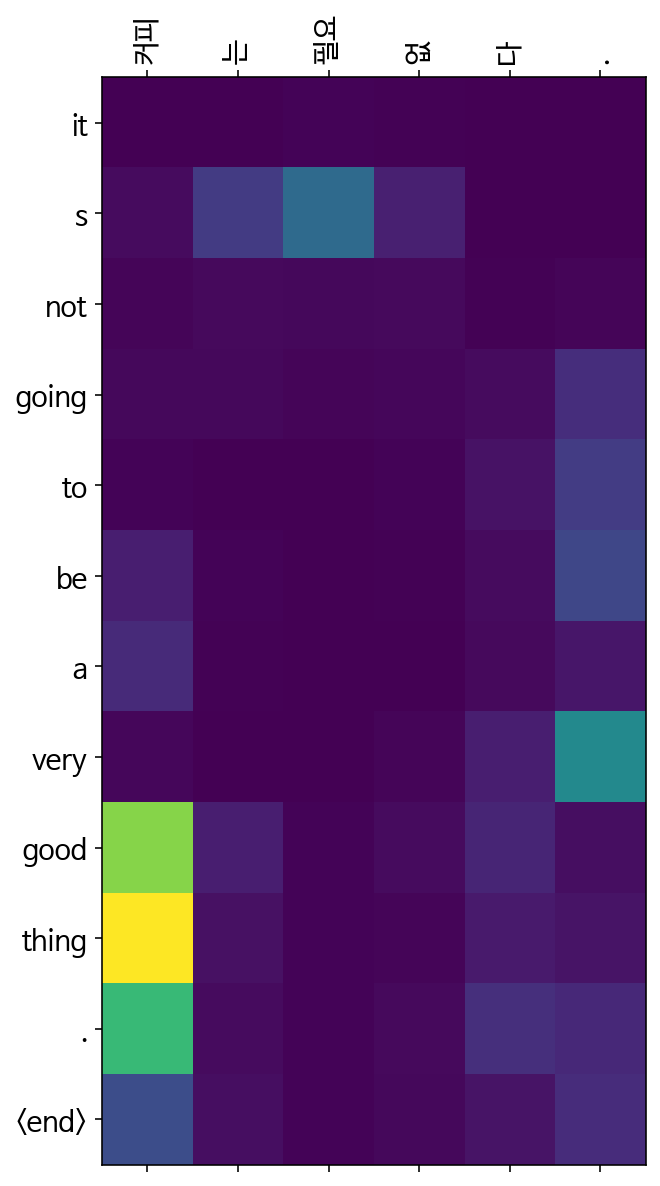

In [68]:
translate(cases[2], encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the death toll was killed in the first time . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


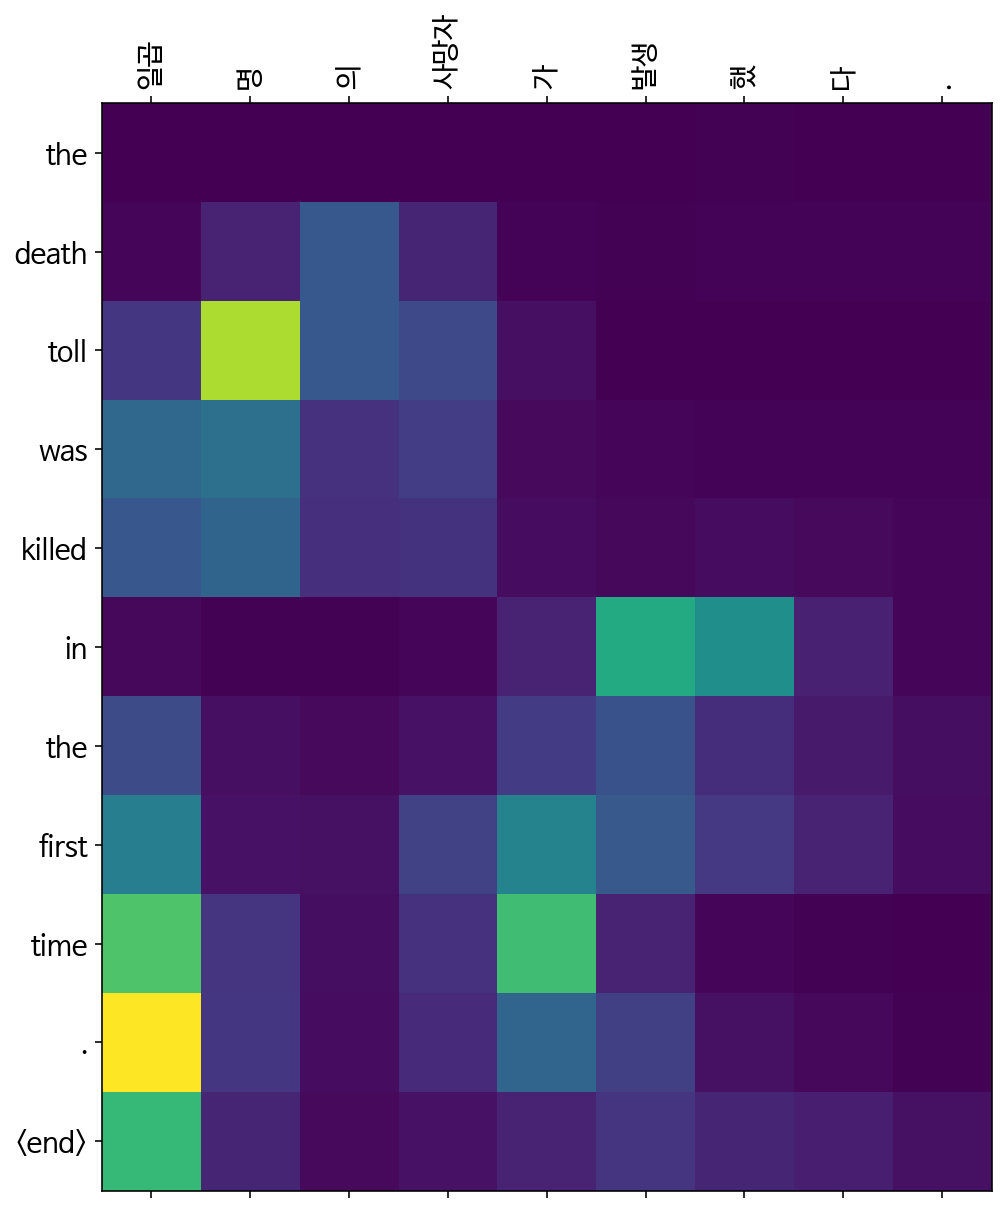

In [69]:
translate(cases[3], encoder, decoder)

In [70]:
EPOCHS = 10
TRIALS = 2

# batch_losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    #tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc[idx:idx+BATCH_SIZE],
                                dec[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        
        batch_losses.append(batch_loss)
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + TRIALS*10 + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 30: 100%|██████████| 970/970 [06:17<00:00,  2.57it/s, Loss 1.8415]


## 30 epoch 결과

/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: 오바마는 대통령이다 .
Predicted translation: obama is the president s going to be the nominee in the next president . <end> 


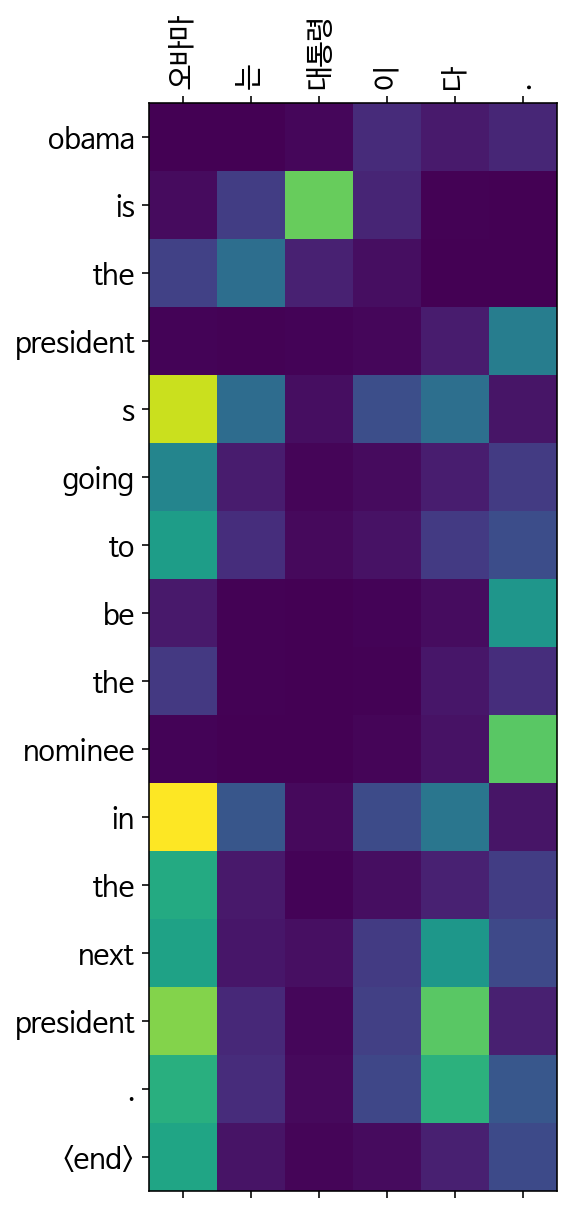

In [71]:
translate(cases[0], encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: they have been a major setback for the past . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


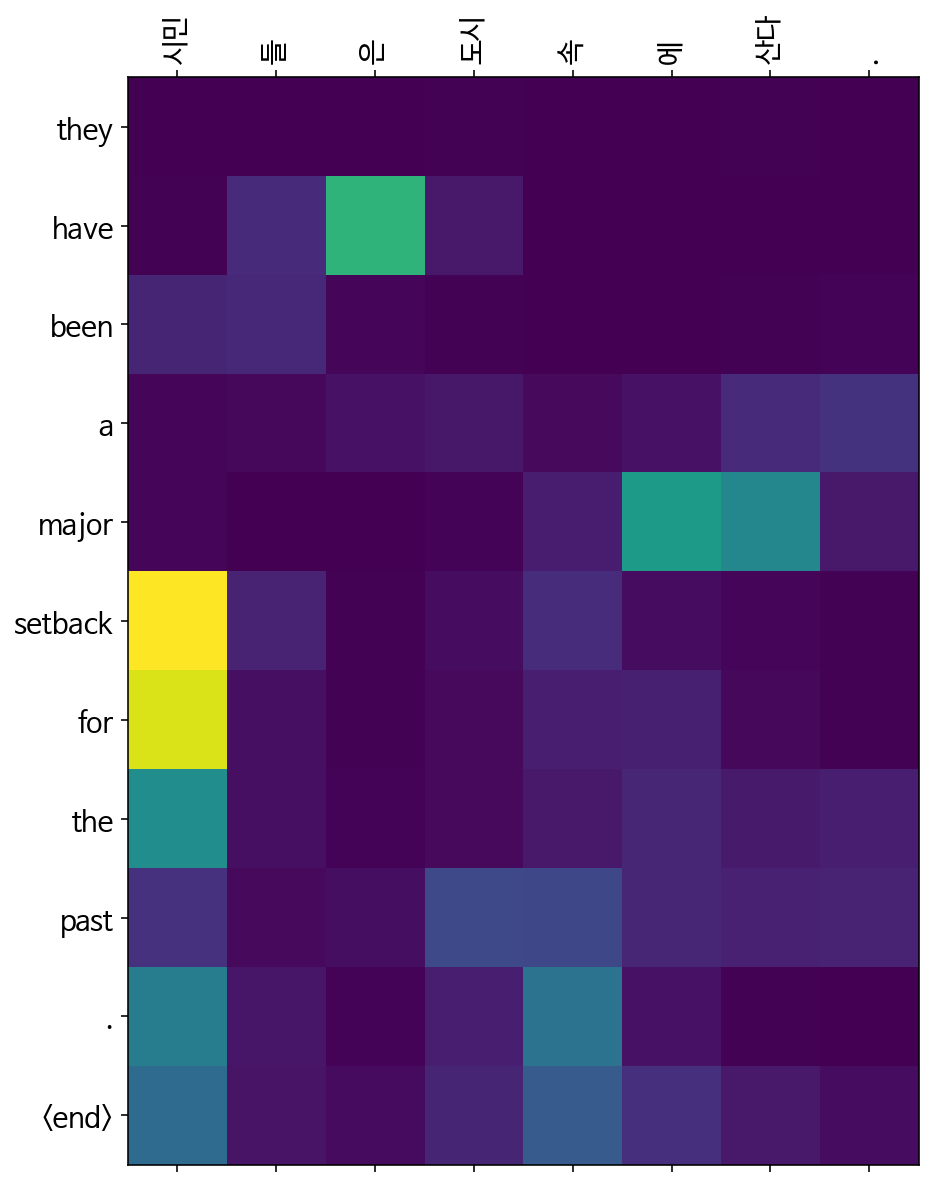

In [72]:
translate(cases[1], encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: you can t be a bit of the same time . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


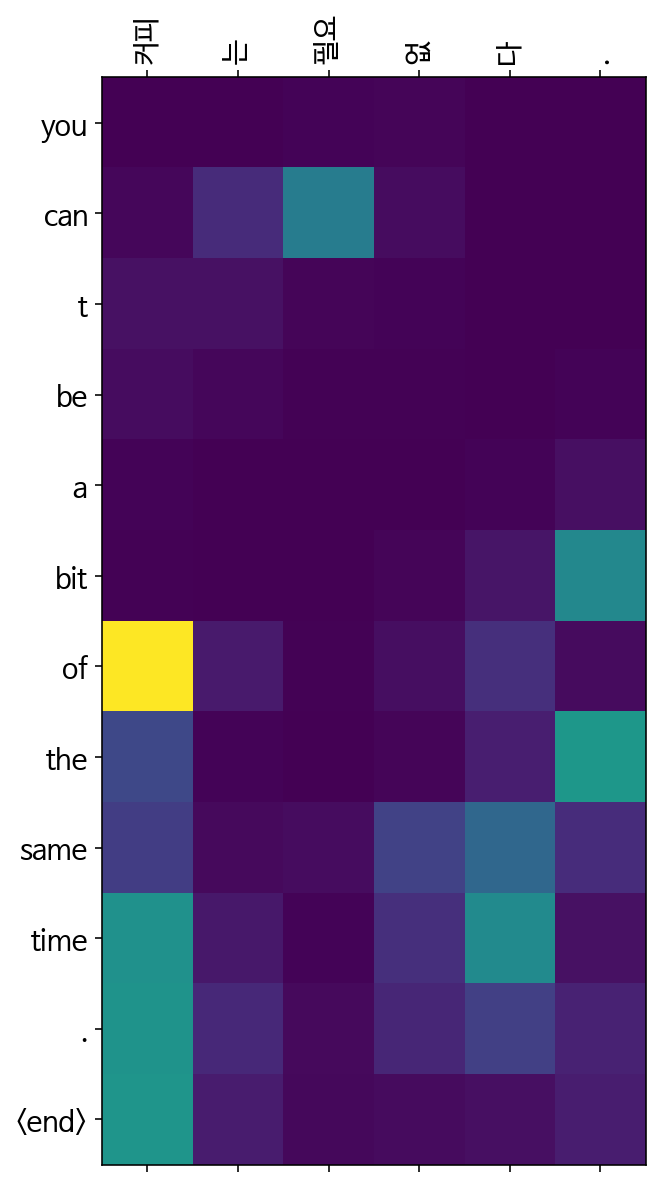

In [73]:
translate(cases[2], encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: more than people have been killed in the past . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


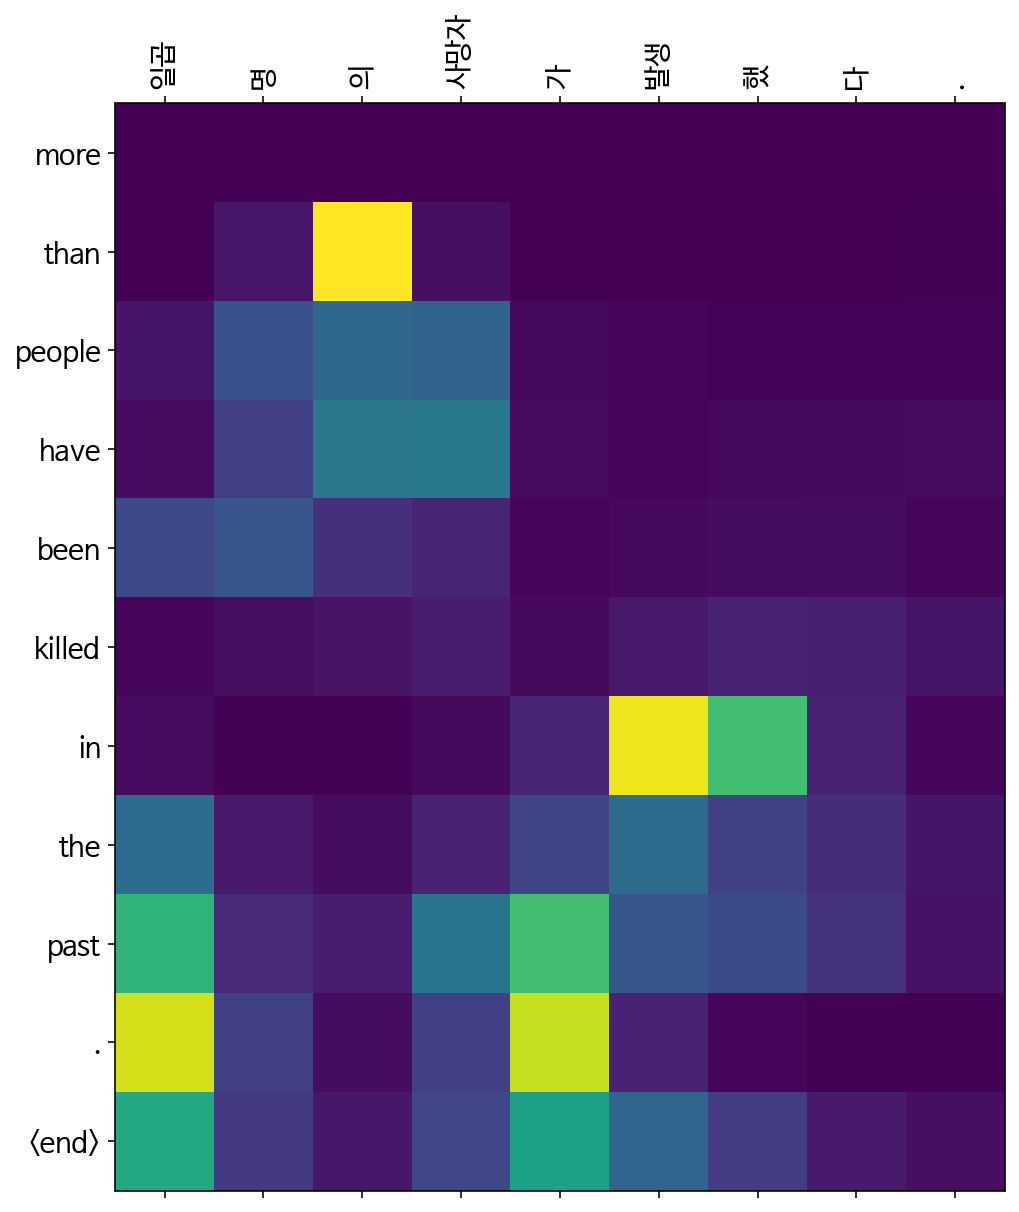

In [74]:
translate(cases[3], encoder, decoder)

In [75]:
EPOCHS = 10
TRIALS = 3

# batch_losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    #tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc[idx:idx+BATCH_SIZE],
                                dec[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        
        batch_losses.append(batch_loss)
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + TRIALS*10 + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 40: 100%|██████████| 970/970 [06:17<00:00,  2.57it/s, Loss 1.5673]


## 40 epoch 결과

/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: 오바마는 대통령이다 .
Predicted translation: obama is a president . <end> 


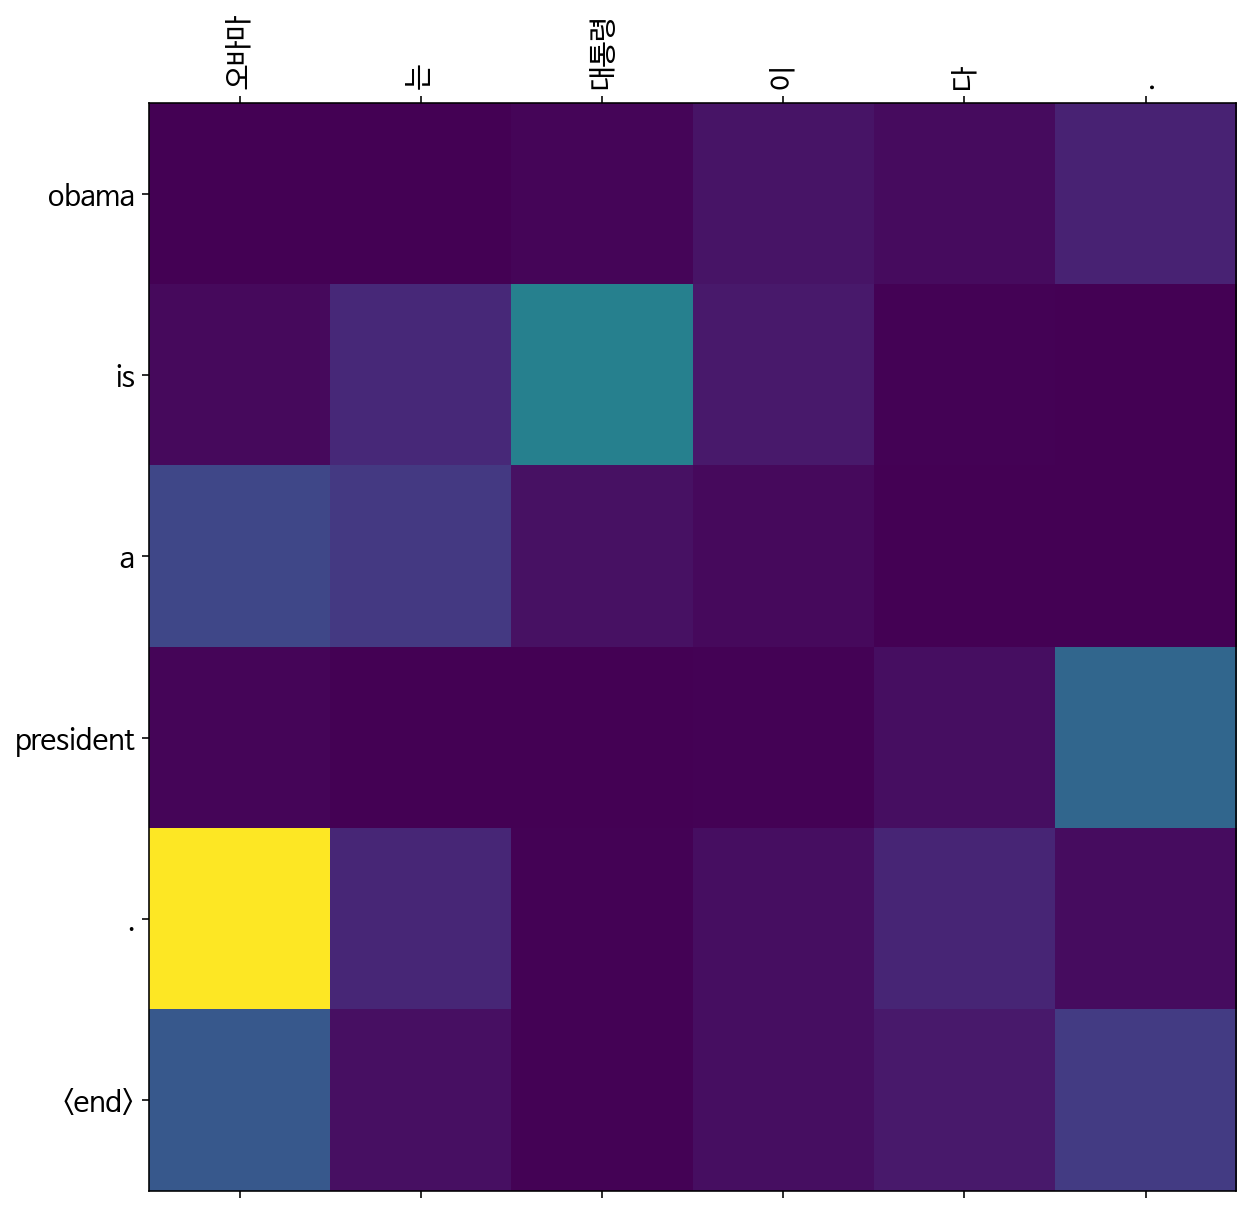

In [76]:
translate(cases[0], encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: they are looking to be a major factor in the city . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


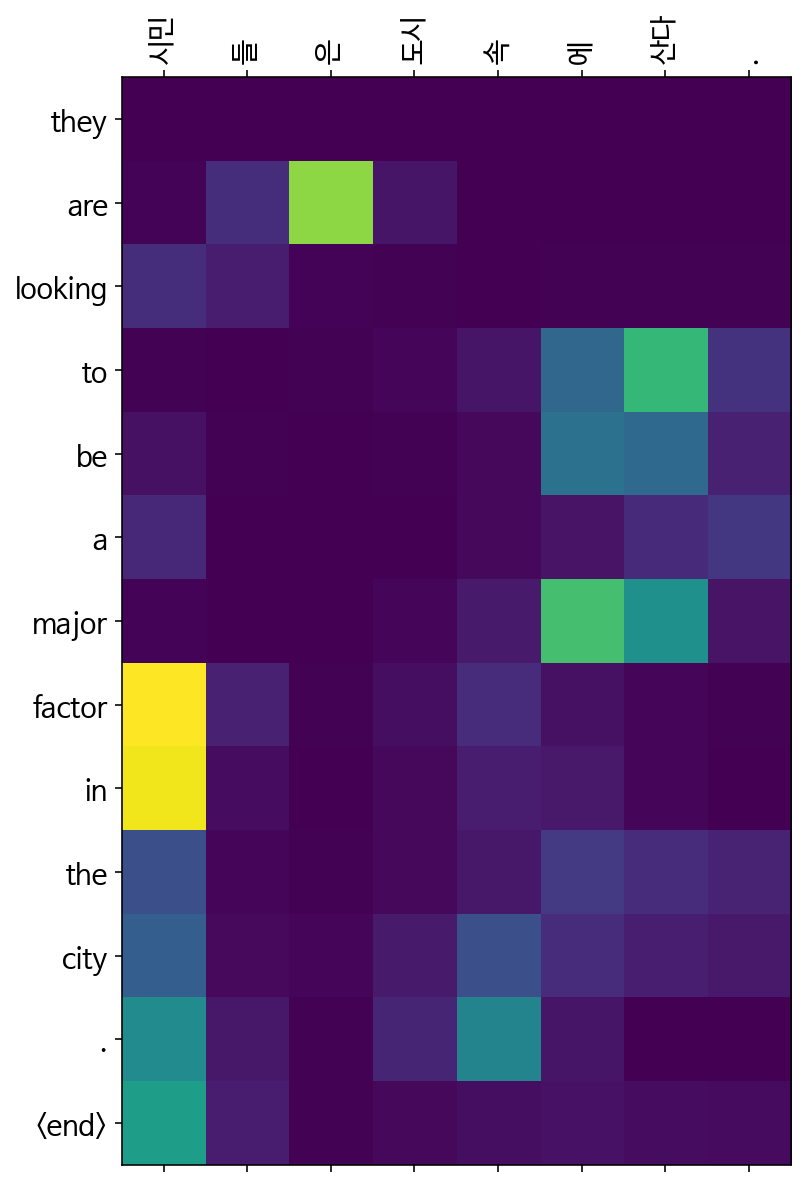

In [77]:
translate(cases[1], encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: you re no preservatives to make your body fat <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


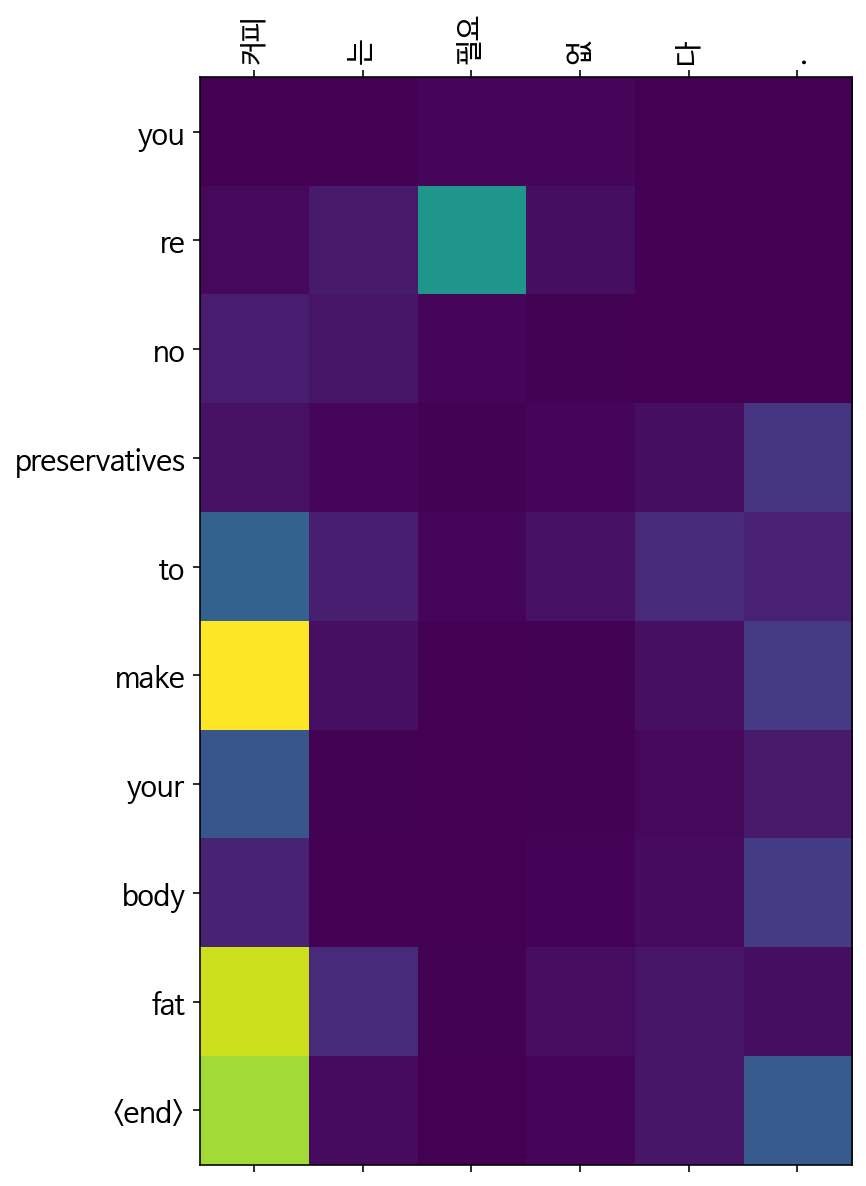

In [78]:
translate(cases[2], encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: two people were killed in the same period . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


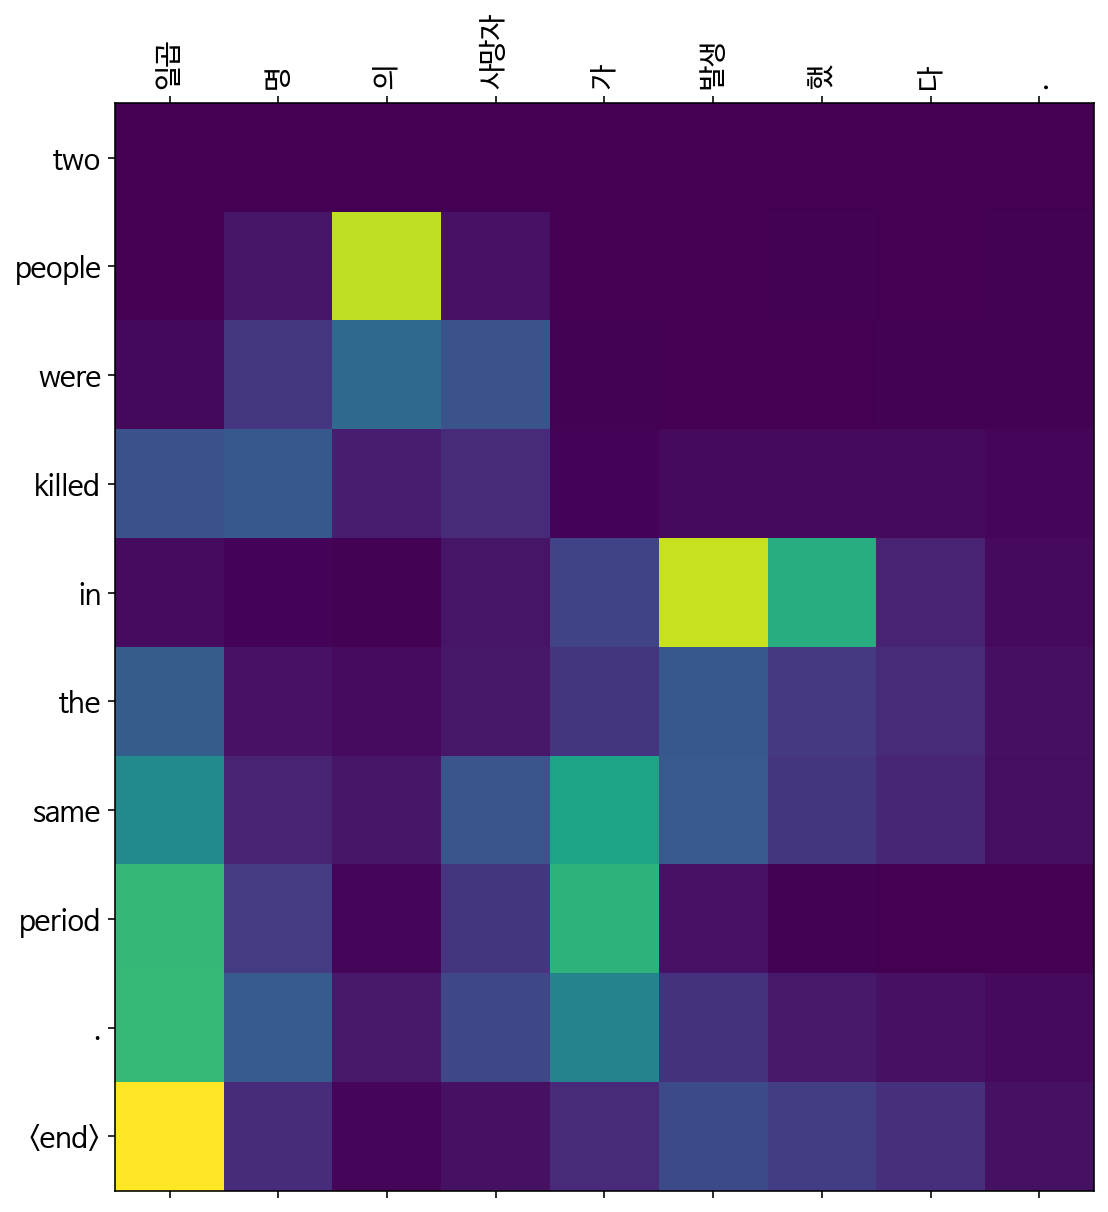

In [79]:
translate(cases[3], encoder, decoder)

In [80]:
EPOCHS = 10
TRIALS = 4

# batch_losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    #tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc[idx:idx+BATCH_SIZE],
                                dec[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        
        batch_losses.append(batch_loss)
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + TRIALS*10 + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 50: 100%|██████████| 970/970 [06:17<00:00,  2.57it/s, Loss 1.3503]


## 50 epoch 결과

/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: 오바마는 대통령이다 .
Predicted translation: obama is the president s plan . <end> 


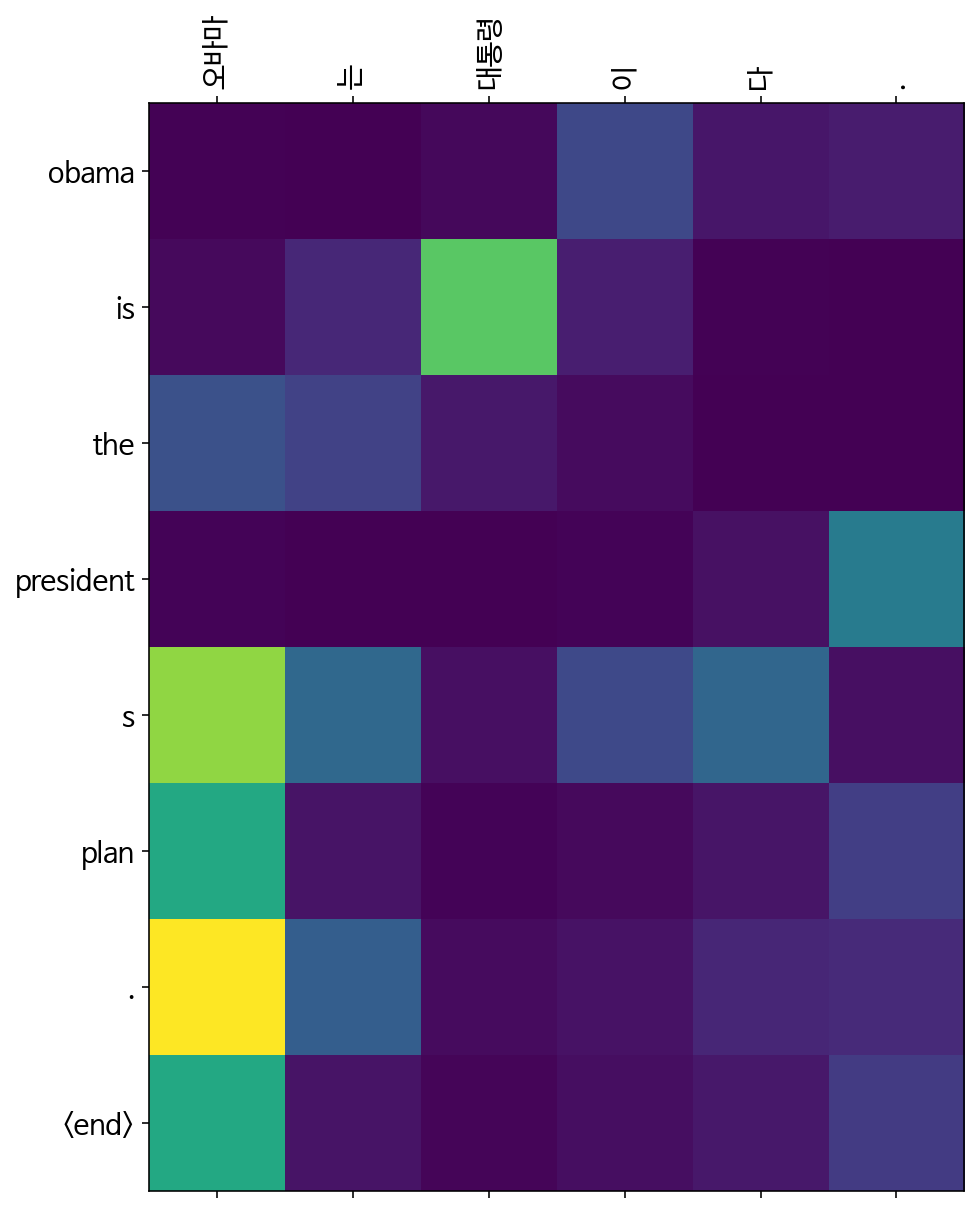

In [81]:
translate(cases[0], encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: they are also a major blow to the city . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


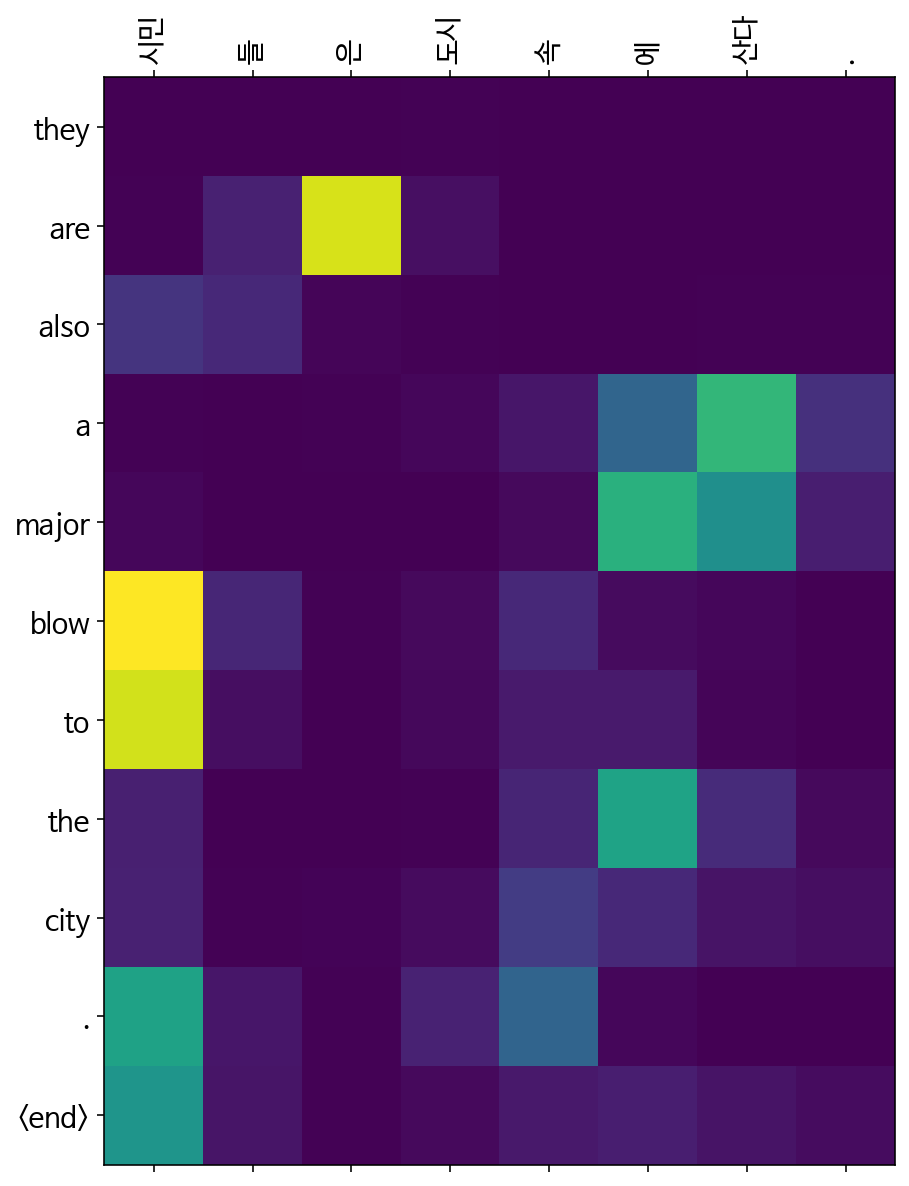

In [82]:
translate(cases[1], encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: caffeine is not easy to be coffee . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


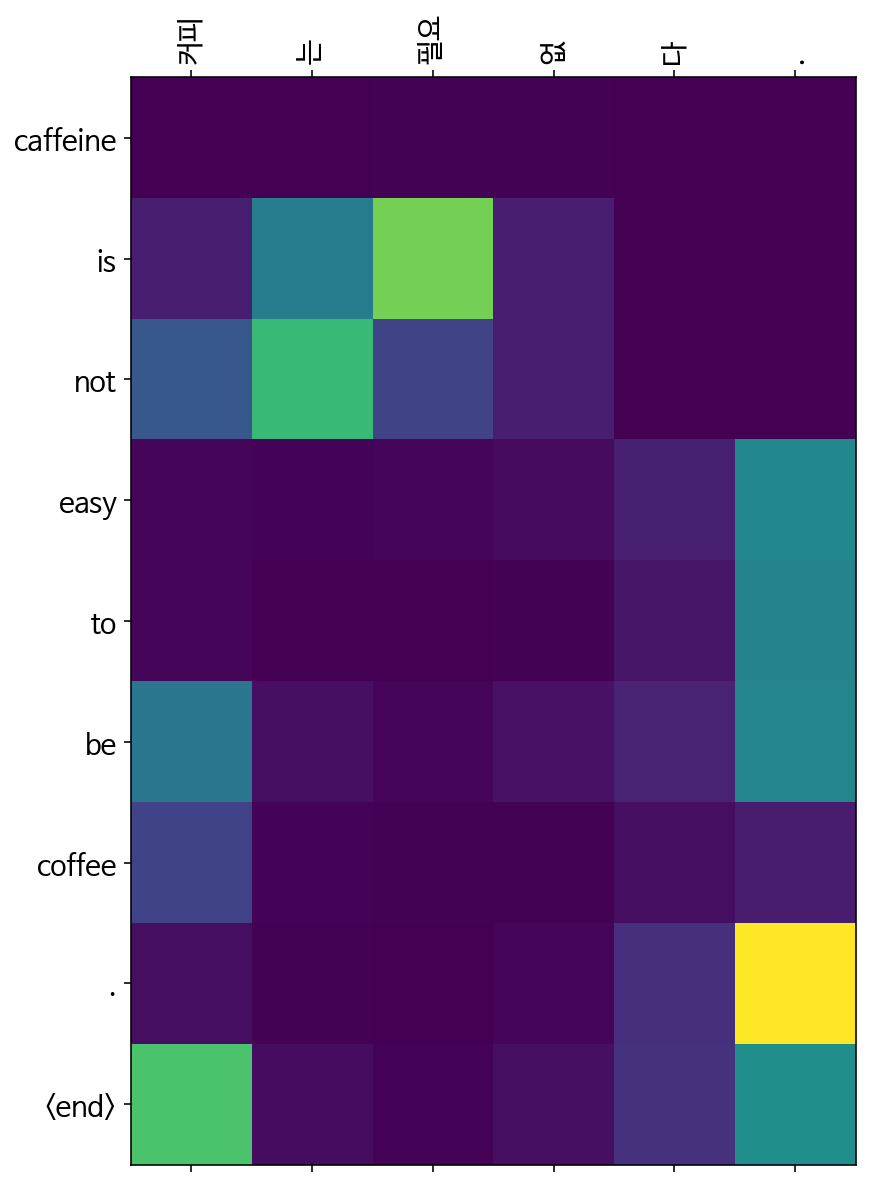

In [83]:
translate(cases[2], encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: two people were killed . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


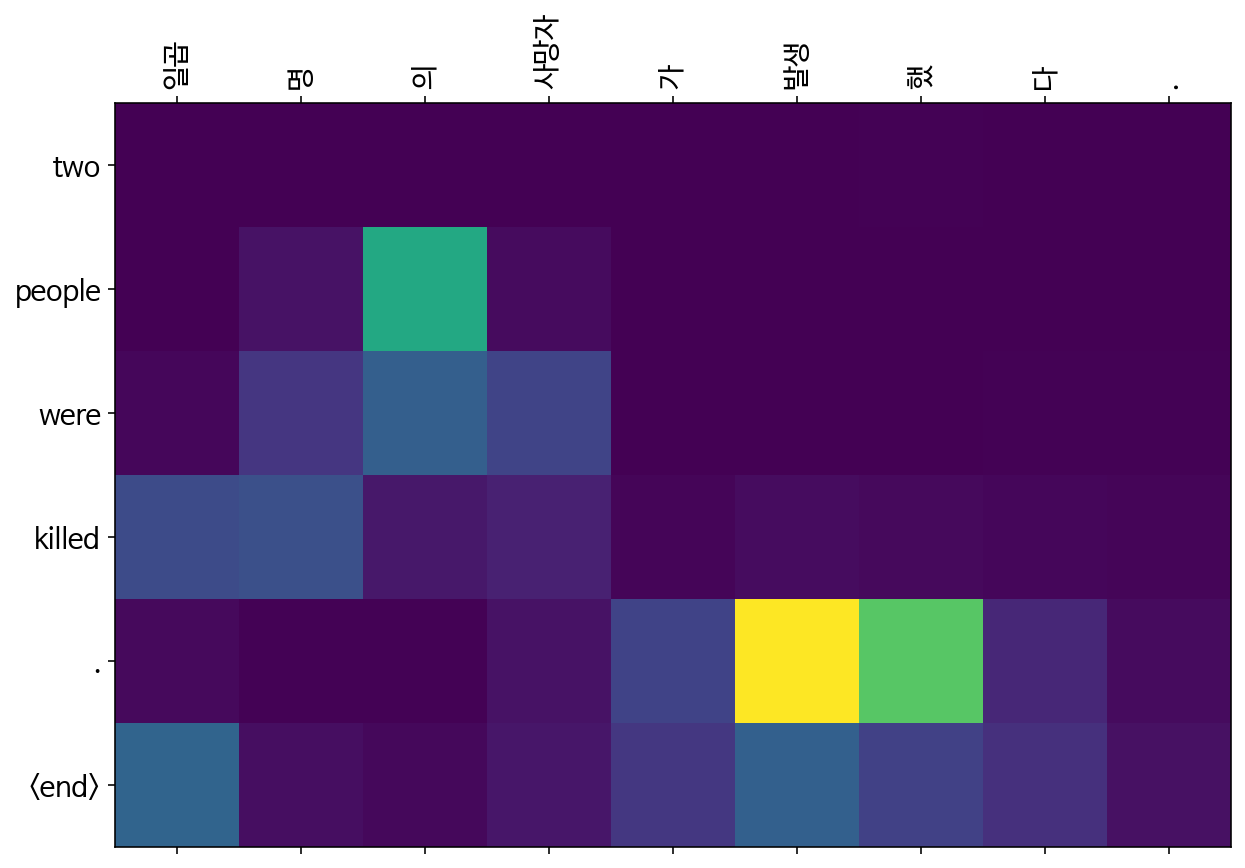

In [84]:
translate(cases[3], encoder, decoder)

In [85]:
EPOCHS = 10
TRIALS = 5

# batch_losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    #tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc[idx:idx+BATCH_SIZE],
                                dec[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        
        batch_losses.append(batch_loss)
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + TRIALS*10 + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 60: 100%|██████████| 970/970 [06:17<00:00,  2.57it/s, Loss 1.1644]


## 60 epoch 결과

/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: 오바마는 대통령이다 .
Predicted translation: obama is weighing in his campaign . <end> 


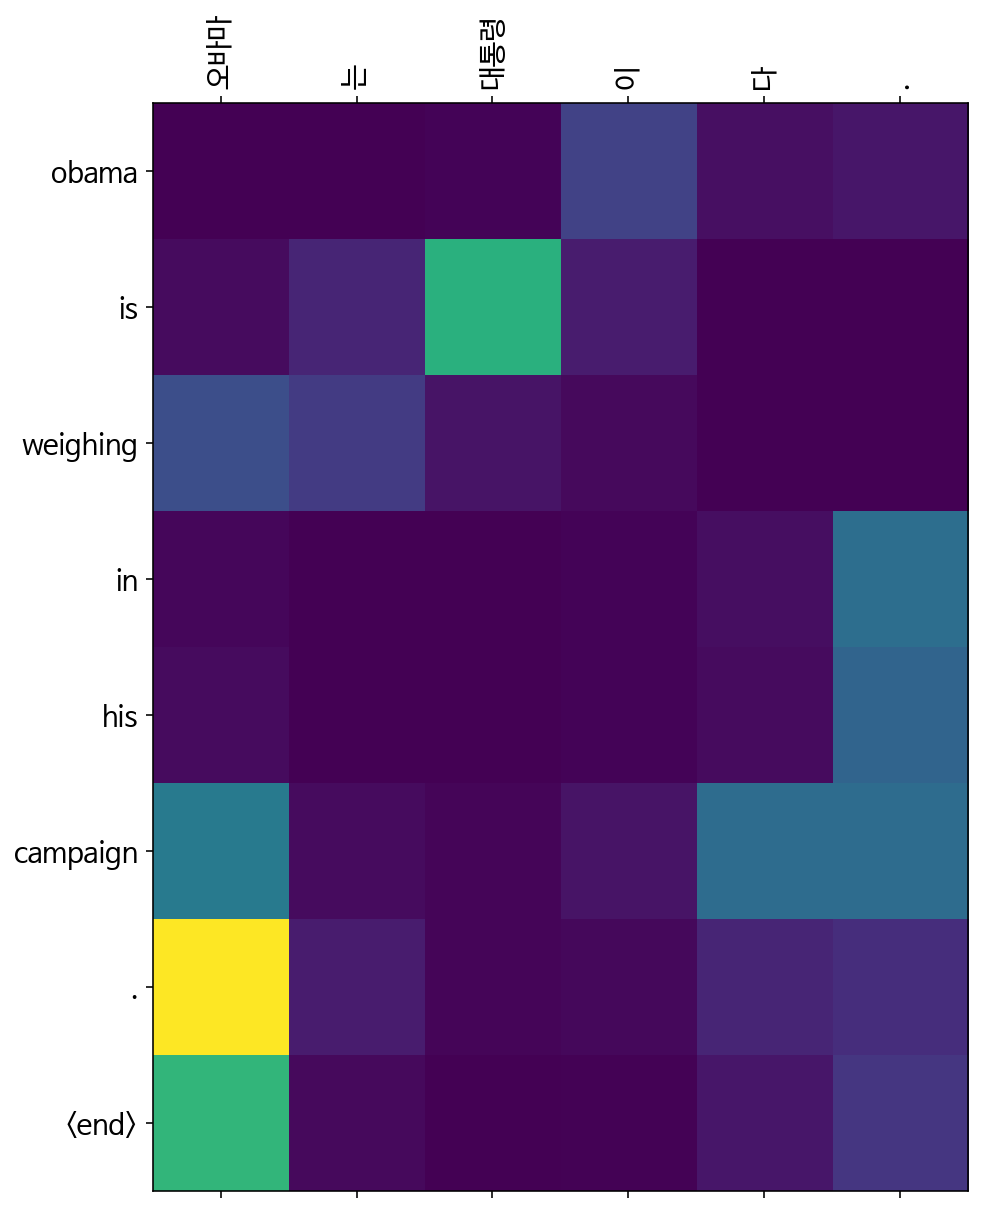

In [86]:
translate(cases[0], encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: fear the city s longest commuting dump in the city s largest city in the city . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


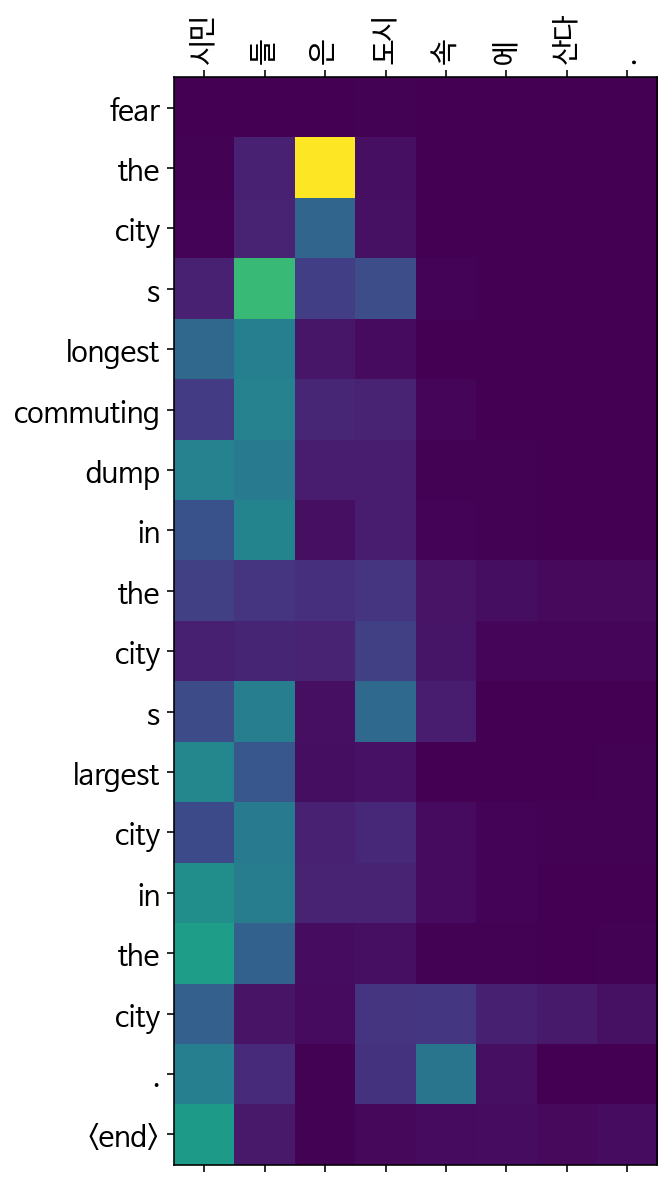

In [87]:
translate(cases[1], encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: if you get a big waste of . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


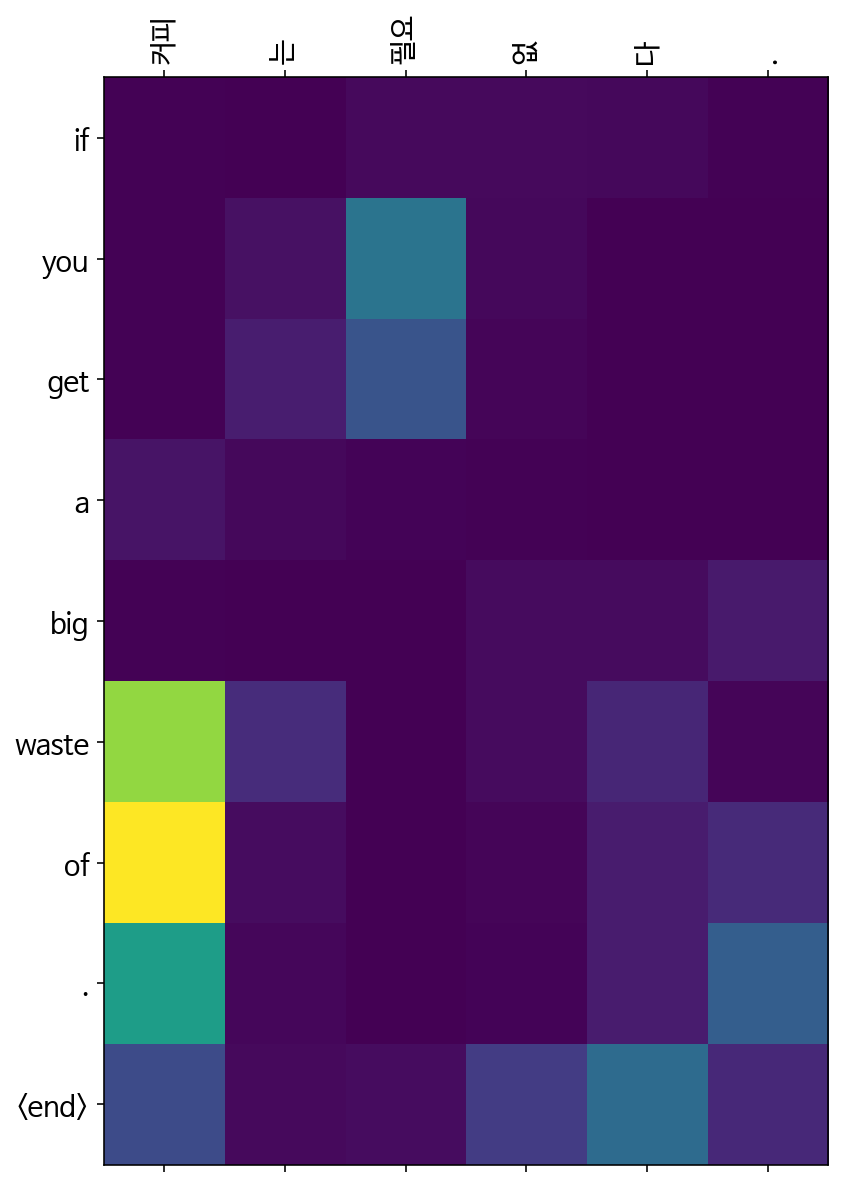

In [88]:
translate(cases[2], encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: seven people were killed in the past . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


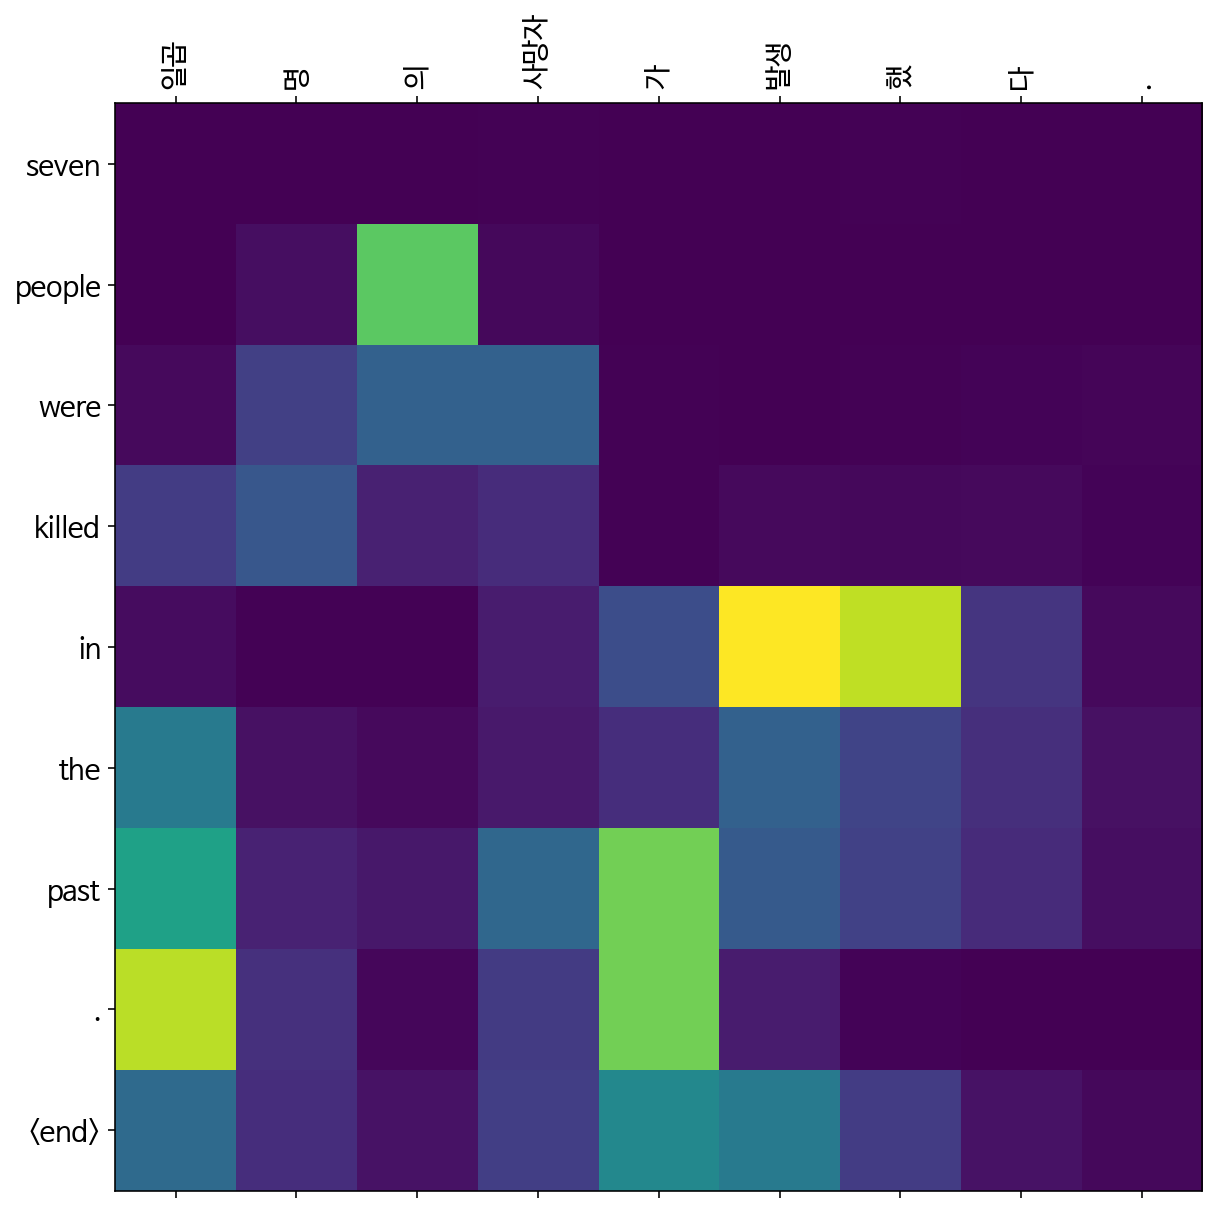

In [89]:
translate(cases[3], encoder, decoder)

In [90]:
EPOCHS = 10
TRIALS = 6

# batch_losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    #tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc[idx:idx+BATCH_SIZE],
                                dec[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        
        batch_losses.append(batch_loss)
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + TRIALS*10 + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 70: 100%|██████████| 970/970 [06:17<00:00,  2.57it/s, Loss 0.9924]


## 70 epoch 결과

/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: 오바마는 대통령이다 .
Predicted translation: obama is the president s plan . <end> 


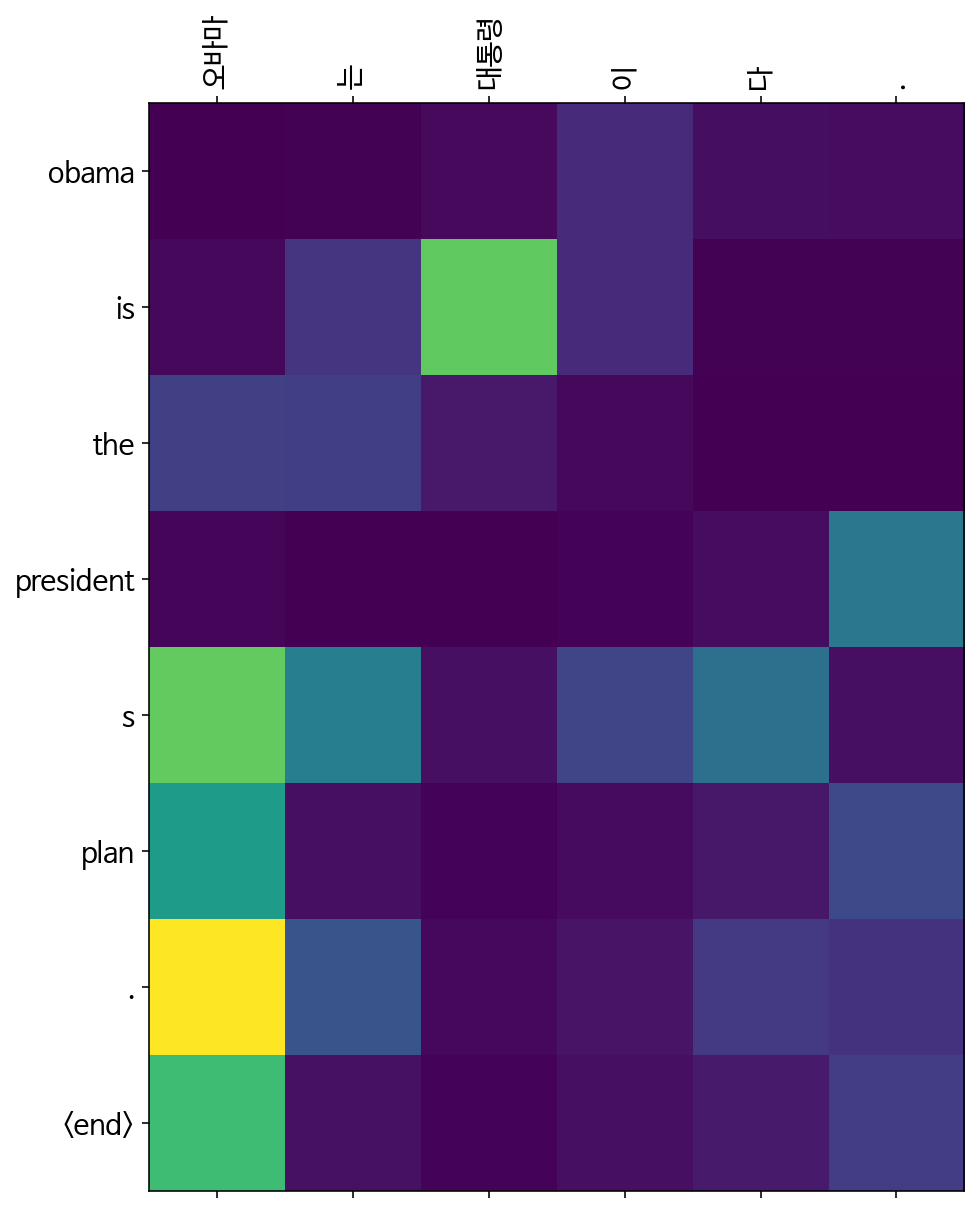

In [91]:
translate(cases[0], encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: fear the number of people traveling at least cities . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


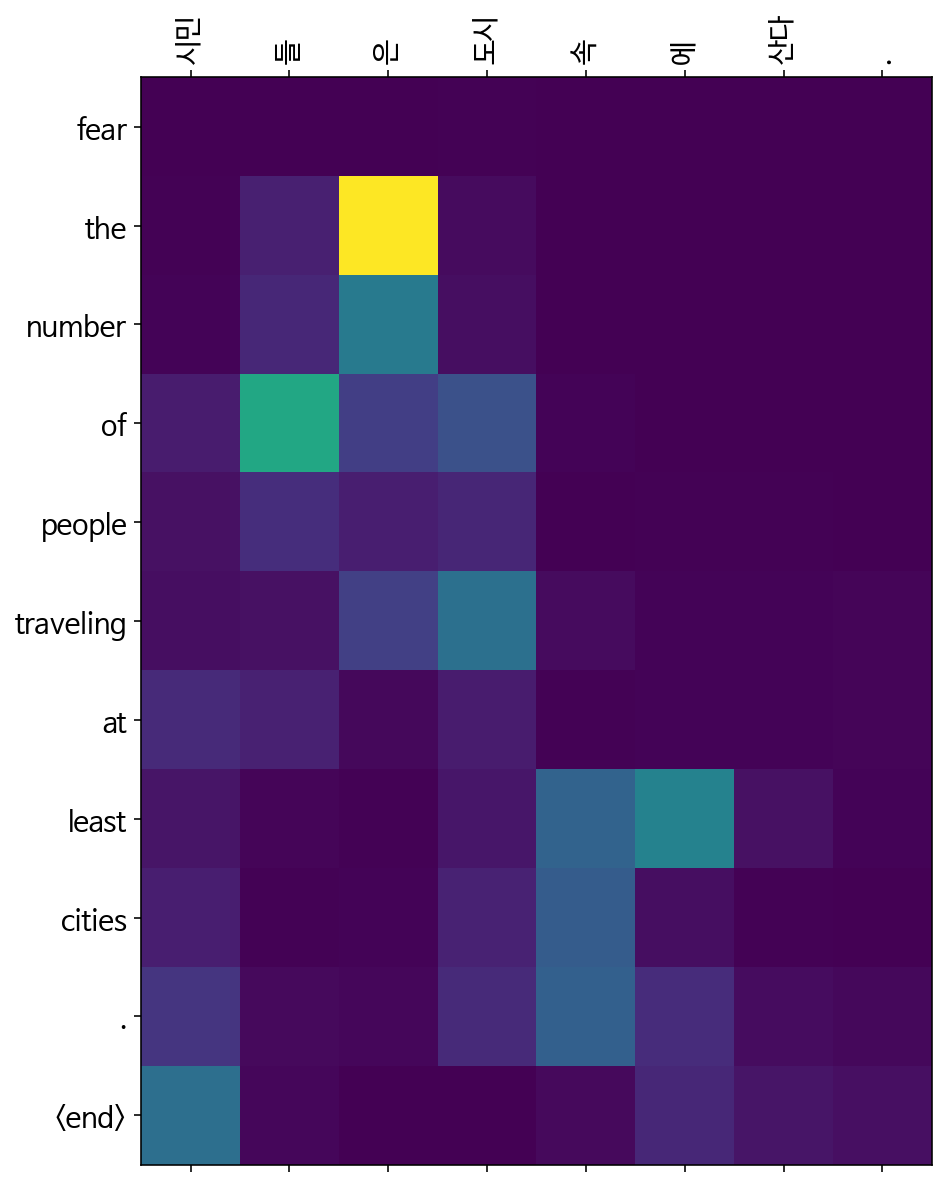

In [92]:
translate(cases[1], encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: caffeine can t be a big waste of . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


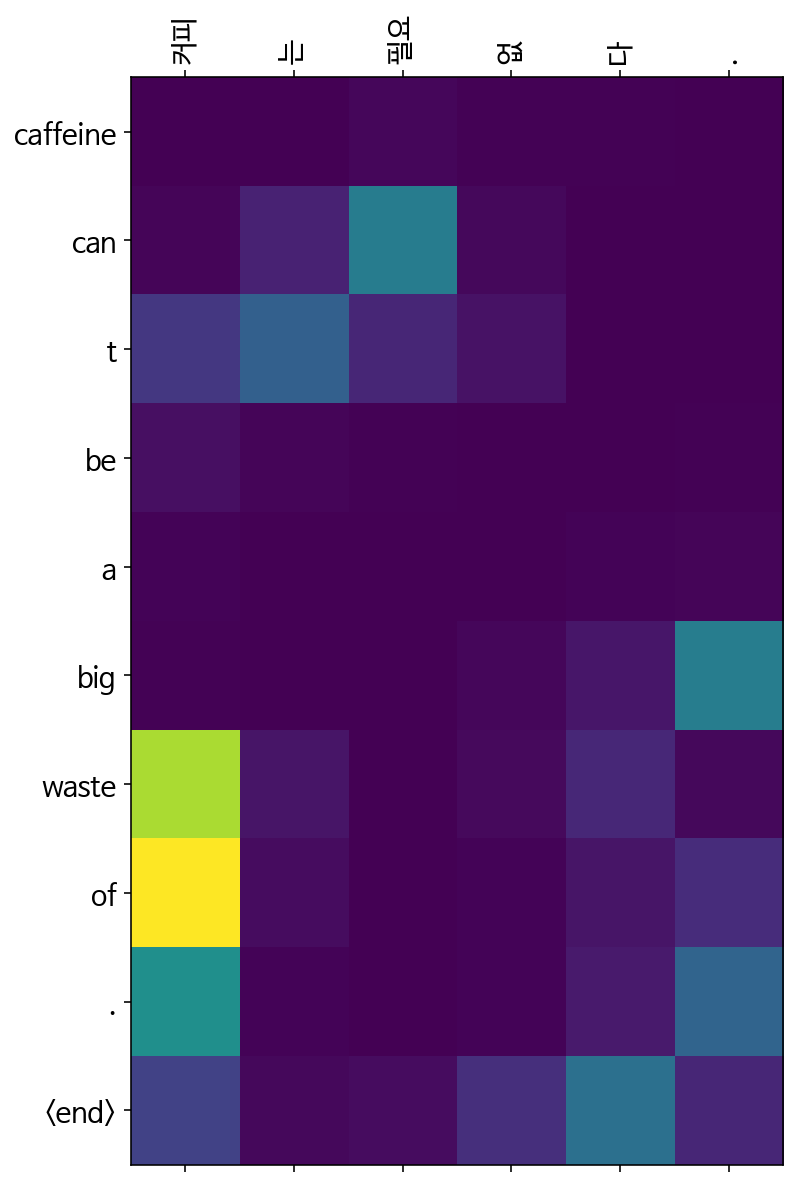

In [93]:
translate(cases[2], encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: seven people were killed in the past . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


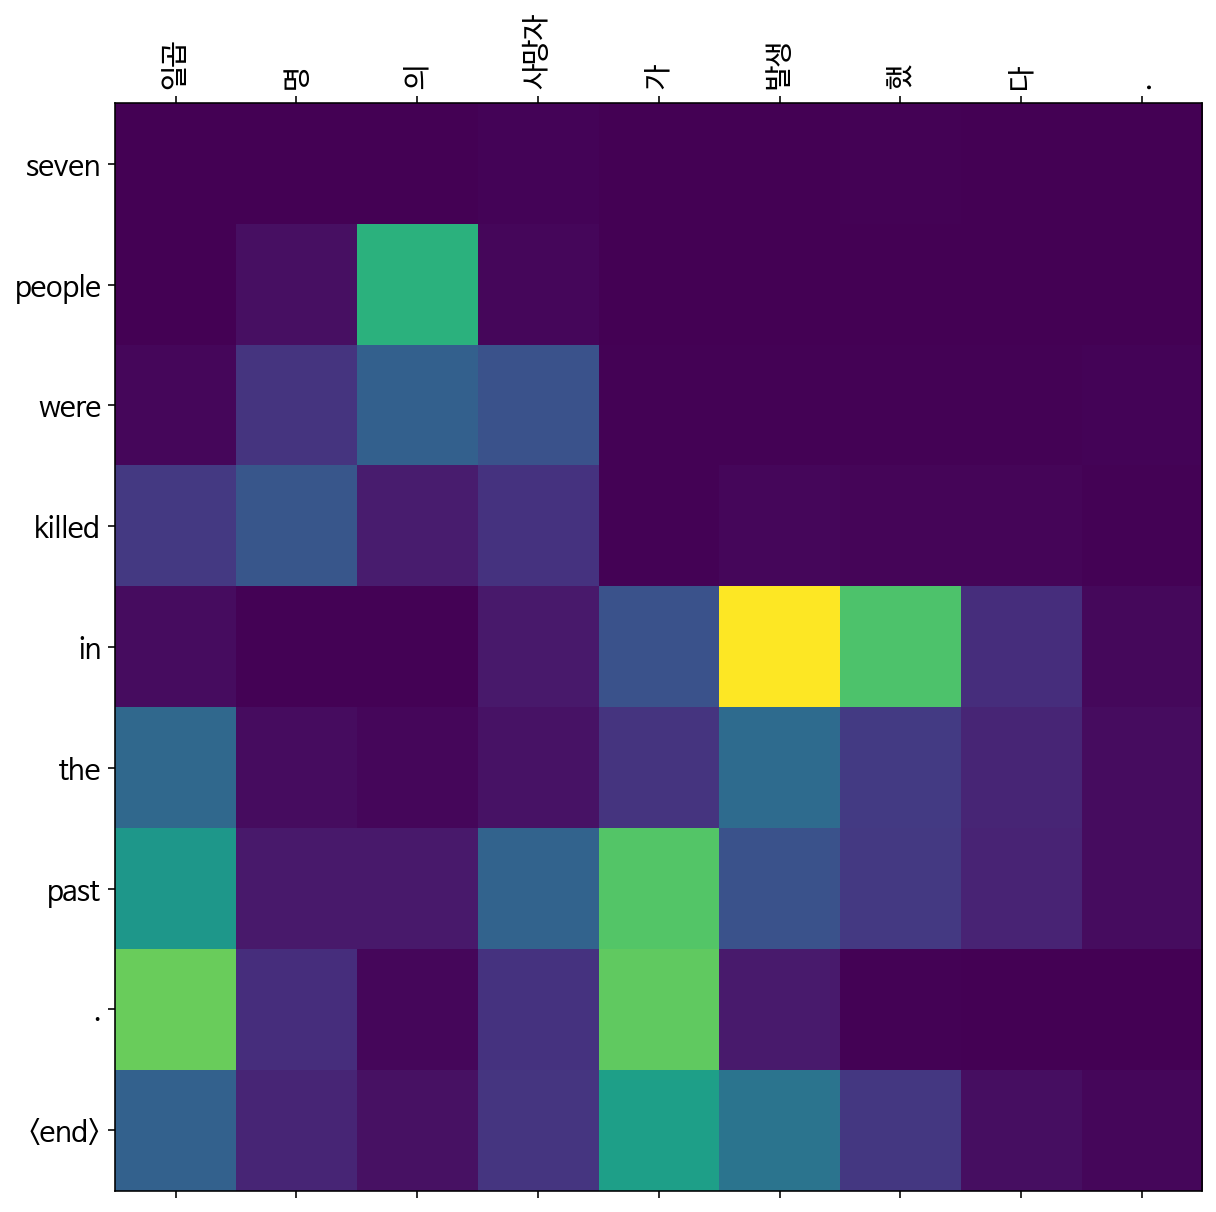

In [94]:
translate(cases[3], encoder, decoder)

In [99]:
EPOCHS = 10
TRIALS = 7

# batch_losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    #tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc[idx:idx+BATCH_SIZE],
                                dec[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        
        batch_losses.append(batch_loss)
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + TRIALS*10 + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 80: 100%|██████████| 970/970 [06:17<00:00,  2.57it/s, Loss 0.8546]


## 80 epoch 결과

/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: 오바마는 대통령이다 .
Predicted translation: obama is weighing in the president s nomination . <end> 


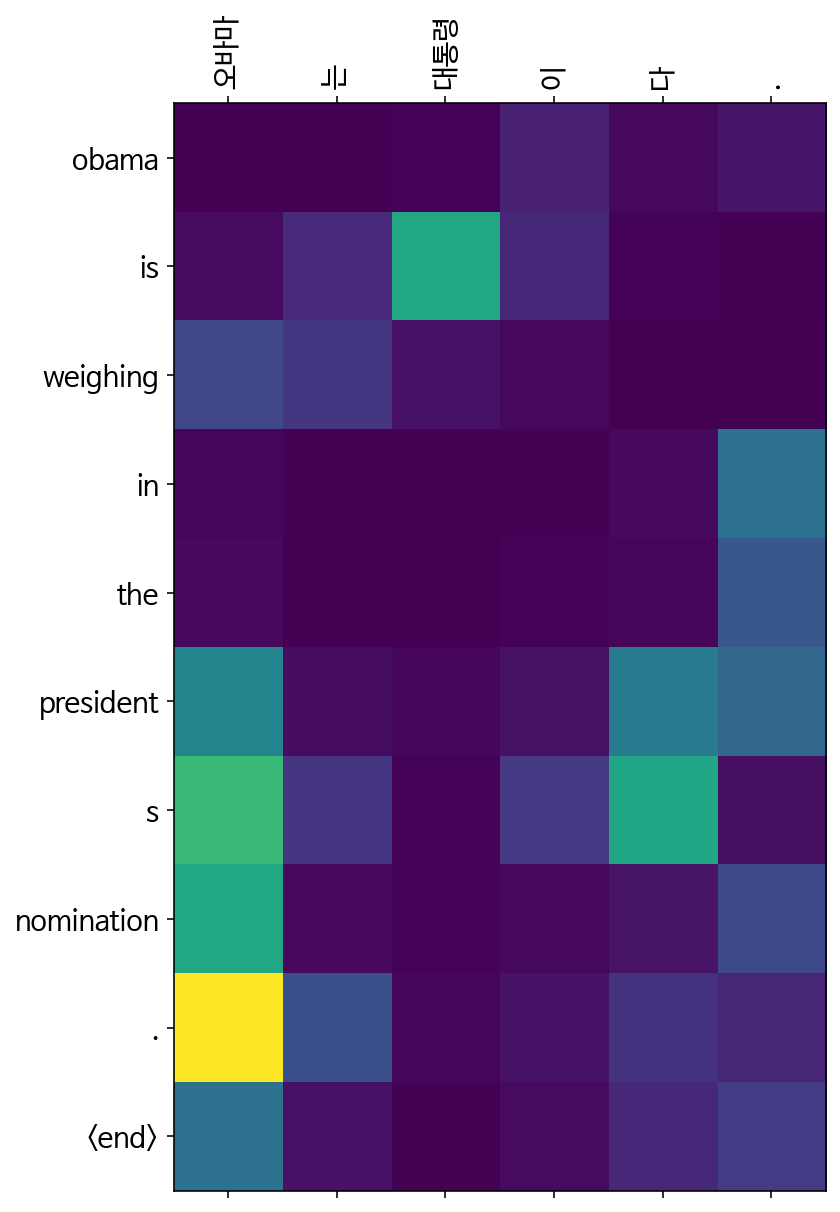

In [100]:
translate(cases[0], encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: angry at the city s longest bitter decline in the city . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


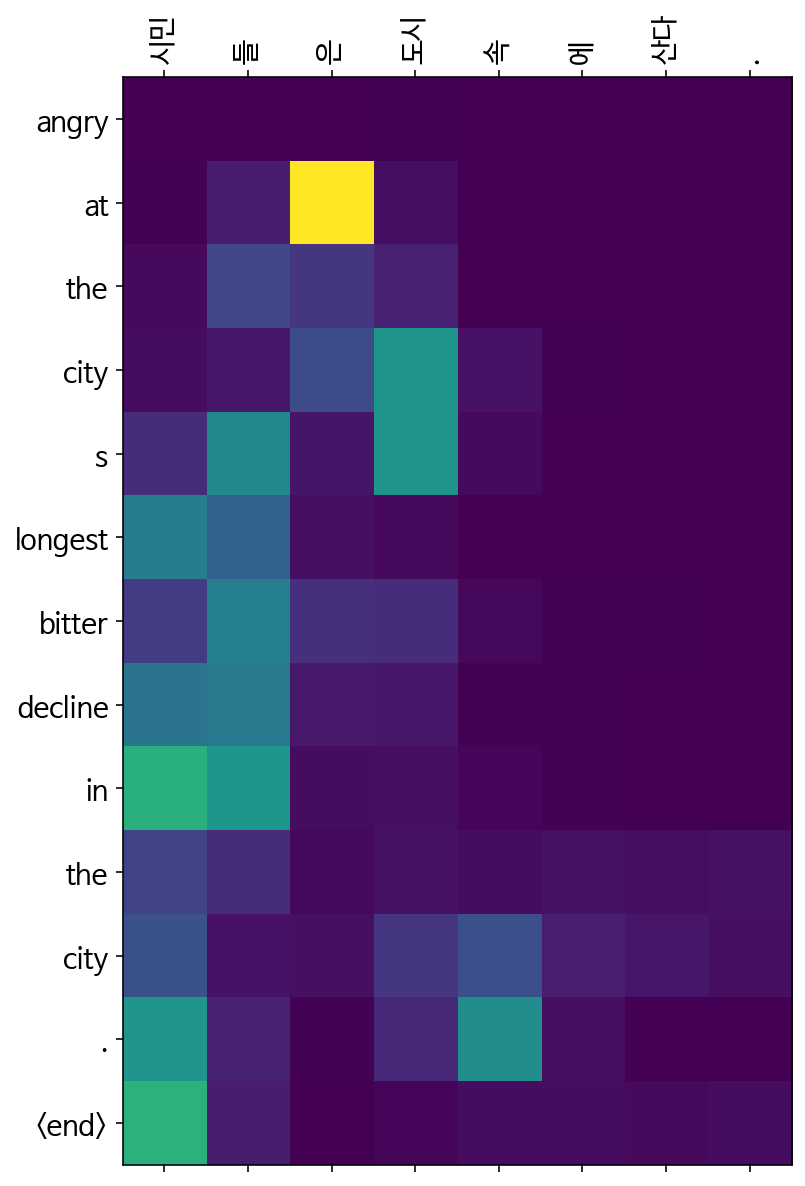

In [101]:
translate(cases[1], encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: find your body weight . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


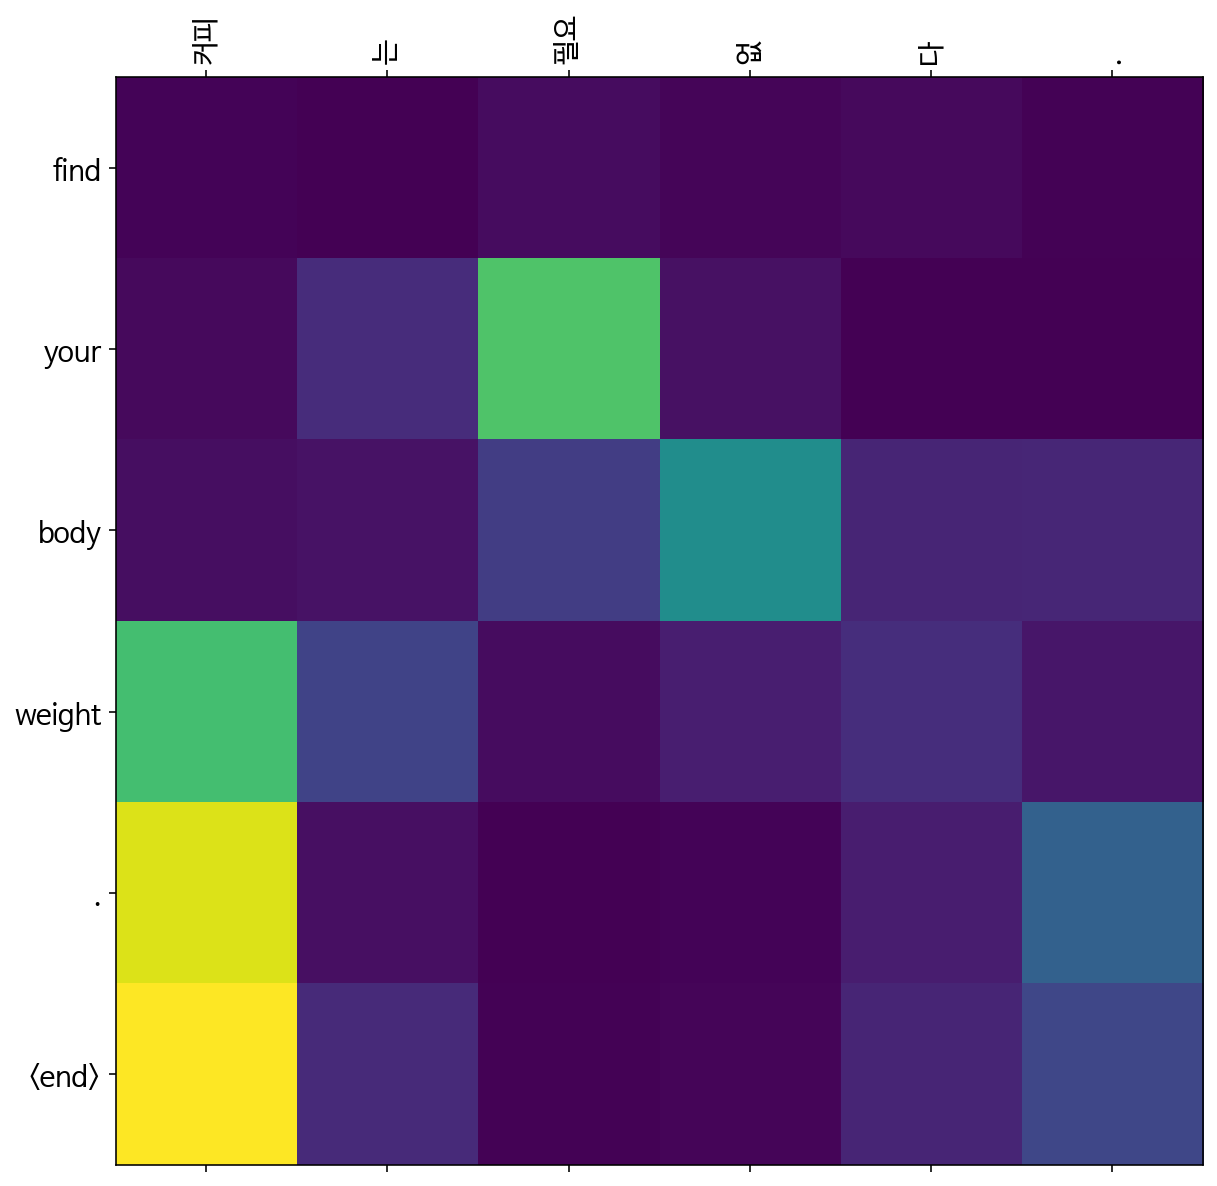

In [104]:
translate(cases[2], encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: seven people were killed in the past . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


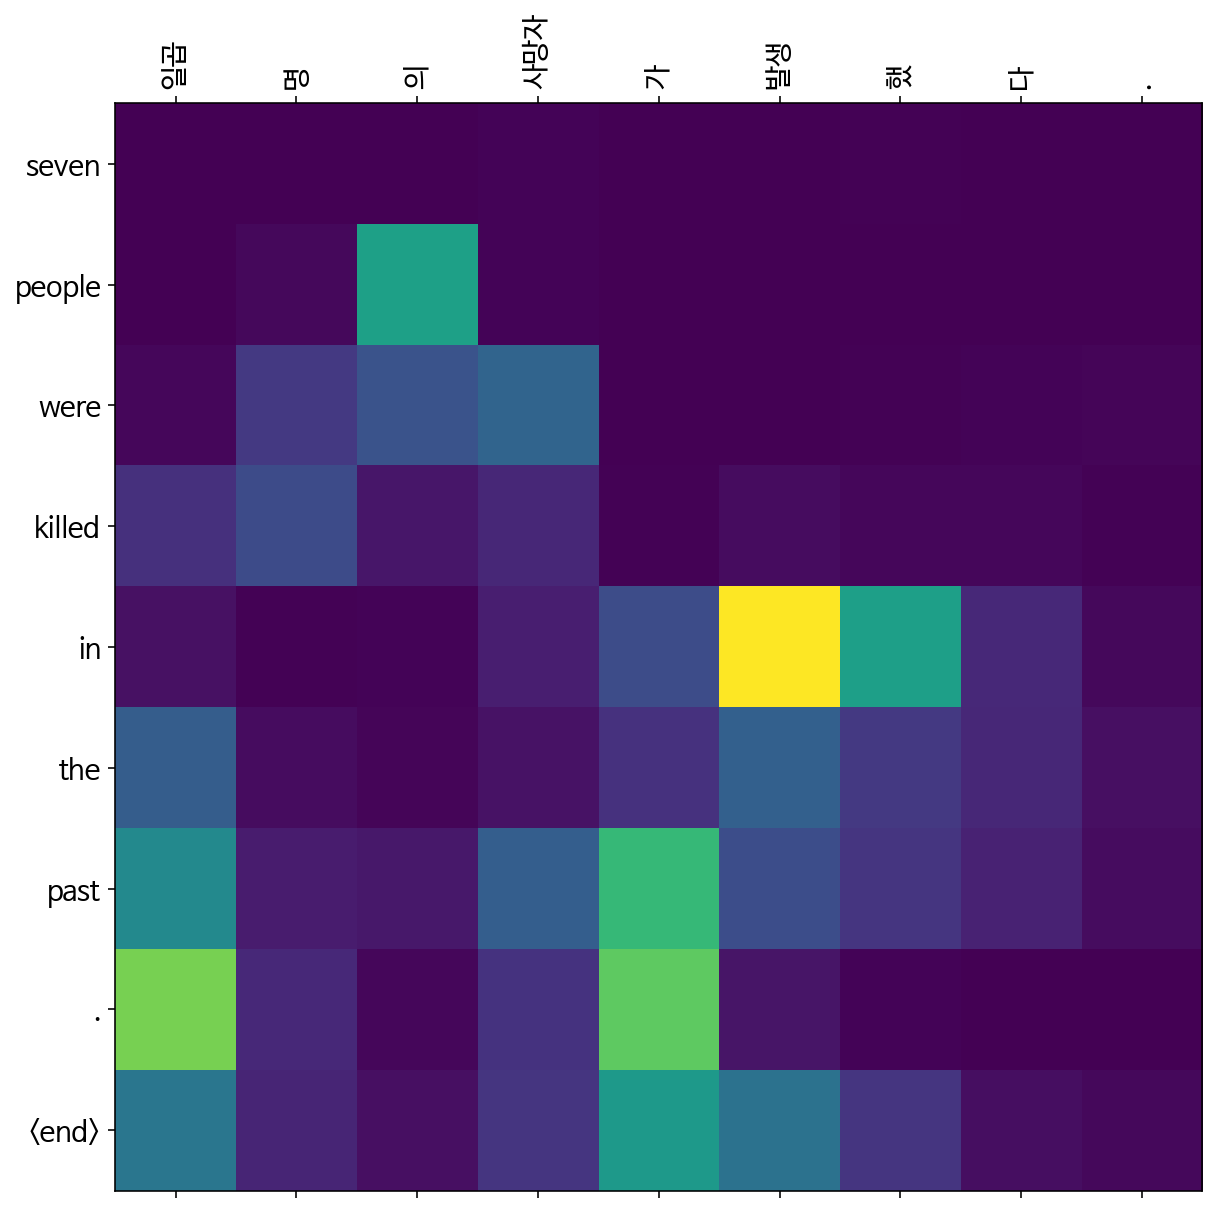

In [103]:
translate(cases[3], encoder, decoder)

Input: 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다 .
Predicted translation: people in the oval office for recommendations it s right to the security and the visa waiver program . <end> 


/tmp/ipykernel_407/172256009.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_407/172256009.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


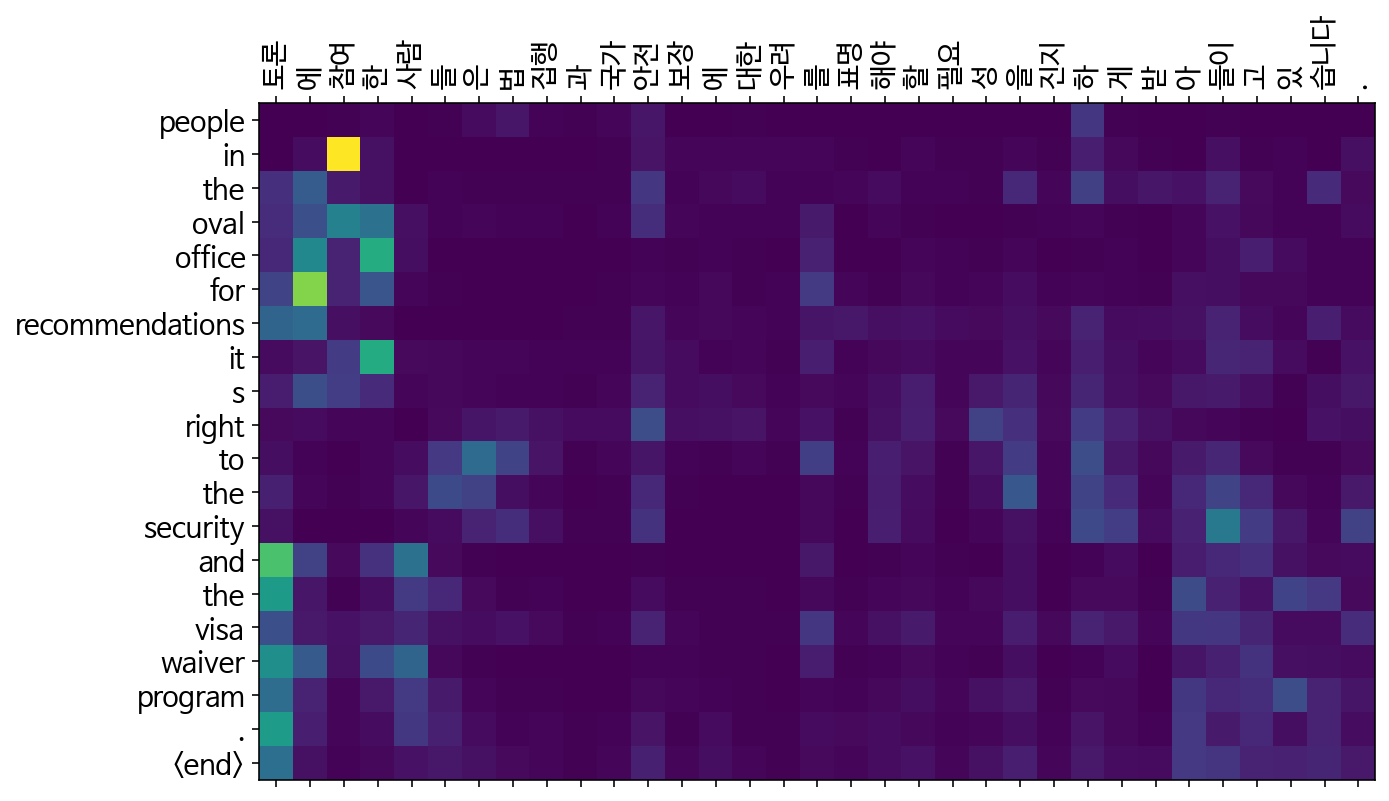

In [118]:
test_data = corpus.test[0].text

translate(test_data, encoder, decoder)

In [119]:
corpus.test[0].pair

'Those involved in the discussions do take seriously the need to address concerns of law enforcement and national security.'

## 에폭별 번역 결과 분석 및 해석

### 원문 문장
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

### 에폭별 번역 결과

| Epoch | 번역 1 | 번역 2 | 번역 3 | 번역 4 |
|-------|--------|--------|--------|--------|
| **10** | obama is the first time. <end> | the year old girl is the first time. <end> | i m a lot of the world s. <end> | the attack was killed in the capital. <end> |
| **20** | obama is the first time. <end> | they are also expected to be a major scale of the world. <end> | it s not going to be a very good thing. <end> | the death toll was killed in the first time. <end> |
| **30** | the death toll was killed in the first time. <end> | they have been a major setback for the past. <end> | you can t be a bit of the same time. <end> | more than people have been killed in the past. <end> |
| **40** | obama is a president. <end> | they are looking to be a major factor in the city. <end> | you re no preservatives to make your body fat. <end> | two people were killed in the same period. <end> |
| **50** | obama is the president s plan. <end> | they are also a major blow to the city. <end> | caffeine is not easy to be coffee. <end> | two people were killed. <end> |
| **60** | obama is weighing in his campaign. <end> | fear the city s longest commuting dump in the city s largest city in the city. <end> | if you get a big waste of. <end> | seven people were killed in the past. <end> |
| **70** | obama is the president s plan. <end> | fear the number of people traveling at least cities. <end> | caffeine can t be a big waste of. <end> | seven people were killed in the past. <end> |
| **80** | obama is weighing in the president s nomination. <end> | angry at the city s longest bitter decline in the city. <end> | find your body weight. <end> | seven people were killed in the past. <end> |

### 해석

- **"오바마는 대통령이다."**
  - 초기에는 "오바마는 처음이다." 같은 부정확한 번역이 있었으나, 40 에폭 이후로 "obama is a president."와 같이 점차 개선됨.
  
- **"시민들은 도시 속에 산다."**
  - 번역 결과가 계속해서 원문과 일치하지 않음. 예를 들어, 20 에폭에서 "they are also expected to be a major scale of the world." 같은 비문맥적 번역이 나옴.
  
- **"커피는 필요 없다."**
  - 여러 에폭 동안 번역의 일관성이 부족하고 문맥에 맞지 않는 결과가 자주 발생함. 예를 들어, 50 에폭에서는 "caffeine is not easy to be coffee."와 같이 원문과 의미가 크게 벗어남.
  
- **"일곱 명의 사망자가 발생했다."**
  - 초기에는 "the attack was killed in the capital." 같은 잘못된 번역이 있었으나, 30 에폭 이후로 "seven people were killed in the past."와 같은 더 정확한 번역이 나오기 시작.

    
    
### 70 에폭과 80 에폭 비교

- **70 에폭에서의 번역:**
  1. obama is the president s plan. <end> (비교적 일관성 있고 문법적으로도 괜찮음)
  2. fear the number of people traveling at least cities. <end> (문맥이 맞지 않지만, 60 에폭보다 나아짐)
  3. caffeine can t be a big waste of. <end> (여전히 부정확하지만, 약간의 의미가 있음)
  4. seven people were killed in the past. <end> (정확한 번역)

- **80 에폭에서의 번역:**
  1. obama is weighing in the president s nomination. <end> (일관성이 떨어짐)
  2. angry at the city s longest bitter decline in the city. <end> (번역이 더 나빠짐)
  3. find your body weight. <end> (원문과 완전히 다름)
  4. seven people were killed in the past. <end> (여전히 정확)

## 결론
- **번역 품질 향상:** 에폭이 증가함에 따라 일부 문장은 점차 정확한 번역으로 개선됨.
- **지속적인 오류:** 특정 문장은 여전히 번역 품질이 낮고 문맥에 맞지 않는 번역이 빈번함.
- **추가 학습 필요:** 모델의 전반적인 번역 성능을 향상시키기 위해서는 추가적인 학습과 모델 개선이 필요.
----
- **70 에폭이 가장 적절한 시점:** 70 에폭에서 번역의 품질이 가장 좋다는 것을 알 수 있습니다.
- **Overfitting의 징후:** 70 에폭 이후로는 모델이 학습 데이터에 과적합(overfitting)되어 새로운 데이터에 대한 일반화 성능이 떨어짐

따라서, **70 에폭**을 최적의 학습 지점으로 삼고, 그 이후에는 조기 종료(early stopping) 기법을 사용하여 overfitting을 방지하는 것이 좋을 것으로 추정됨

## 회고
- 배운 점 
    - 번역기를 만들기 위해 Seq2seq를 직접 구현하면서 구조를 파악해볼 수 있었다
- 아쉬운 점 
    - 시간이 너무 오래걸려서 시각화 및 문제점을 구체적으로 파악하기 어려웠다
    - 생각보다 좋은 결과가 나오지 않아서 아쉽다
- 느낀 점
    - 시간이 너무 오래걸리고 번역기를 만들기 위해서는 정말 많은 데이터를 통한 학습이 필요한 것 같다.
- 어려웠던 점 
    - dropout layer를 어디에 두어야 할지, 어떻게 모델을 구성해야 더 좋은 성능을 낼 수 있을지 생각하는 것이 어렵다